# **0. Initilization & Load Dataset**

In [52]:
import os
import sys
import random
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
import gc

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from src.utils.visualization import plot_model_metrics
from src.utils.scores import _regression_scores
from src.utils.performance_monitor import timed_mem_call
from src.utils.rolling_origin_cv import RollingOriginTimeSeriesSplit

warnings.filterwarnings('ignore')

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f'Seed: {SEED}')

# Enhanced Performance Monitoring Setup
performance_stats = {}
detailed_performance = {}

Seed: 42


In [19]:
def load_split(file_path, schema_json=None):
    file_path = Path(file_path)
    df = pd.read_csv(file_path, parse_dates=['datetime'])

    y = df['target']
    groups = df['datetime']

    # drop các cột sidecar ra khỏi X (không dùng để fit)
    drop_cols = [c for c in ['target', 'datetime', 'name'] if c in df.columns]
    X = df.drop(columns=drop_cols)

    if schema_json is not None:
        cols = pd.read_json(schema_json, typ='series')
        cols = list(cols.values) if isinstance(cols, pd.Series) else list(cols)
        X = X.reindex(columns=cols, fill_value=0)
    
    print(f'[{file_path.name}] df={df.shape}, X={X.shape}, y={y.shape}')
    print(f'    min/max date: {groups.min().date()} -> {groups.max().date()}\n')

    return X, y, groups, df

In [20]:
# Original có one-hot + sidecar datetime/name
X_train, y_train, g_train, df_train = load_split('../dataset/processed/splits/raw_train.csv')
X_val,   y_val,   g_val,   df_val   = load_split('../dataset/processed/splits/raw_val.csv')
X_test,  y_test,  g_test,  df_test  = load_split('../dataset/processed/splits/raw_test.csv')

# FE có feature top-k + target + sidecar
X_fe_train, y_fe_train, g_fe_train, df_fe_train = load_split('../dataset/processed/splits/fe_train.csv',
                                                             schema_json='../dataset/processed/splits/fe_topk_features.json') 
X_fe_val,   y_fe_val,   g_fe_val,   df_fe_val   = load_split('../dataset/processed/splits/fe_val.csv',
                                                             schema_json='../dataset/processed/splits/fe_topk_features.json')
X_fe_test,  y_fe_test,  g_fe_test,  df_fe_test  = load_split('../dataset/processed/splits/fe_test.csv',
                                                             schema_json='../dataset/processed/splits/fe_topk_features.json')

# DT (dt_* là bộ sau SelectFromModel với sidecar)
X_dt_train, y_dt_train, g_dt_train, df_dt_train = load_split('../dataset/processed/splits/dt_train.csv',
                                                             schema_json='../dataset/processed/splits/dt_selected_columns.json')
X_dt_val,   y_dt_val,   g_dt_val,   df_dt_val   = load_split('../dataset/processed/splits/dt_val.csv',
                                                             schema_json='../dataset/processed/splits/dt_selected_columns.json')
X_dt_test,  y_dt_test,  g_dt_test,  df_dt_test  = load_split('../dataset/processed/splits/dt_test.csv',
                                                             schema_json='../dataset/processed/splits/dt_selected_columns.json')

# FE + DT (fe_dt_* sau FE và SelectFromModel, có sidecar)
X_fe_dt_train, y_fe_dt_train, g_fe_dt_train, df_fe_dt_train = load_split('../dataset/processed/splits/fe_dt_train.csv',
                                                                         schema_json='../dataset/processed/splits/fe_dt_selected_columns.json')
X_fe_dt_val,   y_fe_dt_val,   g_fe_dt_val,   df_fe_dt_val   = load_split('../dataset/processed/splits/fe_dt_val.csv',
                                                                         schema_json='../dataset/processed/splits/fe_dt_selected_columns.json')
X_fe_dt_test,  y_fe_dt_test,  g_fe_dt_test,  df_fe_dt_test  = load_split('../dataset/processed/splits/fe_dt_test.csv',
                                                                         schema_json='../dataset/processed/splits/fe_dt_selected_columns.json')

[raw_train.csv] df=(59184, 43), X=(59184, 40), y=(59184,)
    min/max date: 2015-01-01 -> 2024-01-01

[raw_val.csv] df=(3276, 43), X=(3276, 40), y=(3276,)
    min/max date: 2024-02-01 -> 2024-07-31

[raw_test.csv] df=(6570, 43), X=(6570, 40), y=(6570,)
    min/max date: 2024-08-31 -> 2025-08-30

[fe_train.csv] df=(59058, 28), X=(59058, 25), y=(59058,)
    min/max date: 2015-01-08 -> 2024-01-01

[fe_val.csv] df=(3150, 28), X=(3150, 25), y=(3150,)
    min/max date: 2024-02-08 -> 2024-07-31

[fe_test.csv] df=(6444, 28), X=(6444, 25), y=(6444,)
    min/max date: 2024-09-07 -> 2025-08-30

[dt_train.csv] df=(59184, 23), X=(59184, 20), y=(59184,)
    min/max date: 2015-01-01 -> 2024-01-01

[dt_val.csv] df=(3276, 23), X=(3276, 20), y=(3276,)
    min/max date: 2024-02-01 -> 2024-07-31

[dt_test.csv] df=(6570, 23), X=(6570, 20), y=(6570,)
    min/max date: 2024-08-31 -> 2025-08-30

[fe_dt_train.csv] df=(59058, 29), X=(59058, 26), y=(59058,)
    min/max date: 2015-01-08 -> 2024-01-01

[fe_dt_val.

# **1. Random Forest**

## 1.1. Find Optimal RF Function

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_rf_timeseries(
    X_train, y_train, groups_train,
    n_estimators_range=(100, 200, 300, 500),
    # tham số cho rolling-origin:
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    metric="mae",
    random_state=SEED,
    n_jobs=-1,
    # tham số RF cốt lõi
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=0.5,
    bootstrap=True,
    plot=True,
):
    # chọn hàm đánh giá
    metric = metric.lower().strip()
    if metric == "mae":
        scorer = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)
        ylabel = "CV MAE (lower is better)"
    elif metric == "rmse":
        scorer = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
        ylabel = "CV RMSE (lower is better)"
    else:
        raise ValueError("metric must be 'mae' or 'rmse'")

    # 2) tạo splitter rolling-origin
    tscv = RollingOriginTimeSeriesSplit(
        date_col=None,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
    )
    splits = list(tscv.split(X=None, groups=groups_train))

    ns = list(n_estimators_range)
    meds, stds = [], []

    for n in ns:
        fold_scores = []
        for tr_idx, va_idx in splits:
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train.iloc[tr_idx]
            y_va = y_train.iloc[va_idx]

            rf = RandomForestRegressor(
                n_estimators=n,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                bootstrap=bootstrap,
                n_jobs=n_jobs,
                random_state=random_state,
            )
            rf.fit(X_tr, y_tr)
            y_pred = rf.predict(X_va)
            fold_scores.append(scorer(y_va, y_pred))

        meds.append(np.median(fold_scores))
        stds.append(np.std(fold_scores))

    # chọn n có điểm số trung vị nhỏ nhất
    best_idx = int(np.argmin(meds))
    best_n = ns[best_idx]

    if plot:
        plt.figure(figsize=(9, 5))
        plt.errorbar(ns, meds, yerr=stds, fmt='o-', capsize=4)
        plt.title(
            f"RF với Rolling-Origin (min_train={min_train_days}d, "
            f"step={step_days}d, horizon={horizon_days}d, gap={gap_days}d)"
        )
        plt.xlabel("n_estimators")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

    print(
        f"n_estimators tối ưu (Rolling-Origin CV): {best_n} | "
        f"{ylabel.split()[0]} = {meds[best_idx]:.4f} ± {stds[best_idx]:.4f}"
    )

    # huấn luyện lại mô hình tốt nhất trên toàn bộ train
    best_model = RandomForestRegressor(
        n_estimators=best_n,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        random_state=random_state,
    )
    best_model.fit(X_train, y_train)

    cv_table = {
        "n_estimators": ns,
        "cv_median": meds,
        "cv_std": stds,
        "metric": metric,
    }
    return best_model, best_n, cv_table

## 1.2. Evaluate Function 

In [ ]:
#đánh giá trên tập validation
def evaluate_val_rf_reg(
    X_train, y_train, groups_train,
    X_val, y_val, 
    n_estimators_range=(100, 200, 300, 500),
    # tham số cho rolling-origin:
    min_train_days=365*5, step_days=30, horizon_days=7, gap_days=30,
    max_splits=None, metric="mae", random_state=SEED, n_jobs=-1,
    # tham số RF cốt lõi
    max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=0.5,
    bootstrap=True,
    plot=True
):
    """
    Tìm n_estimators tối ưu bằng RollingOriginTimeSeriesSplit trên (X_train, y_train),
    sau đó đánh giá trên tập validation (X_val, y_val) với MAE/RMSE/R2.
    """
    print('Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)')

    best_model, best_n, cv_table = find_optimal_rf_timeseries(
        X_train, y_train, groups_train,
        n_estimators_range=n_estimators_range,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
        metric=metric,
        random_state=random_state,
        n_jobs=n_jobs,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        plot=plot,
    )

    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print(f'\nHiệu năng trên Validation:')
    print(f'  MAE : {val_mae:.4f}')
    print(f'  RMSE: {val_rmse:.4f}')
    print(f'  R2  : {val_r2:.4f}')

    meta = {
        "n_estimators": best_n,
        "cv": cv_table,
        "cv_config": {
            "min_train_days": min_train_days,
            "step_days": step_days,
            "horizon_days": horizon_days,
            "gap_days": gap_days,
            "max_splits": max_splits,
        },
    }
    scores = {"val_mae": val_mae, "val_rmse": val_rmse, "val_r2": val_r2}
    return best_model, scores, meta

# đánh giá trên tập test
def evaluate_test_rf_reg(rf_model, X_test, y_test):
    """
    Đánh giá mô hình RF đã chọn trên tập test hold-out
    (Không cần groups ở đây vì ta chỉ predict 1 lần)
    """
    test_pred = rf_model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print(f'\nHiệu năng trên Test:')
    print(f'  MAE : {test_mae:.4f}')
    print(f'  RMSE: {test_rmse:.4f}')
    print(f'  R2  : {test_r2:.4f}')

    return {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

## 1.3. 4-Way Evaluation of Random Forest:
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


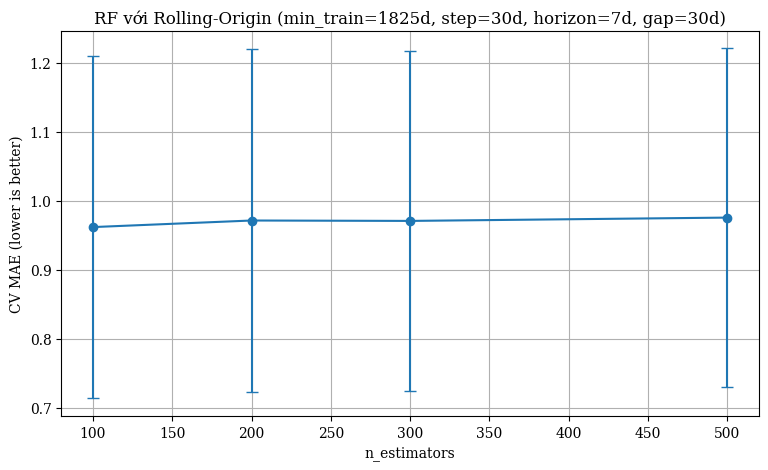

n_estimators tối ưu (Rolling-Origin CV): 100 | CV = 0.9618 ± 0.2484

Hiệu năng trên Validation:
  MAE : 0.9971
  RMSE: 1.2377
  R²  : 0.6774
[RF Original (CV+Val)] time=844.11s | Py-peak=73.8 MB | RSS(before/after/delta)=498.7/1926.2/1427.5 MB

Hiệu năng trên Test:
  MAE : 1.0119
  RMSE: 1.3184
  R²  : 0.5853
[RF Original (Test)] time=0.03s | Py-peak=2.4 MB | RSS(before/after/delta)=1926.3/1929.0/2.6 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


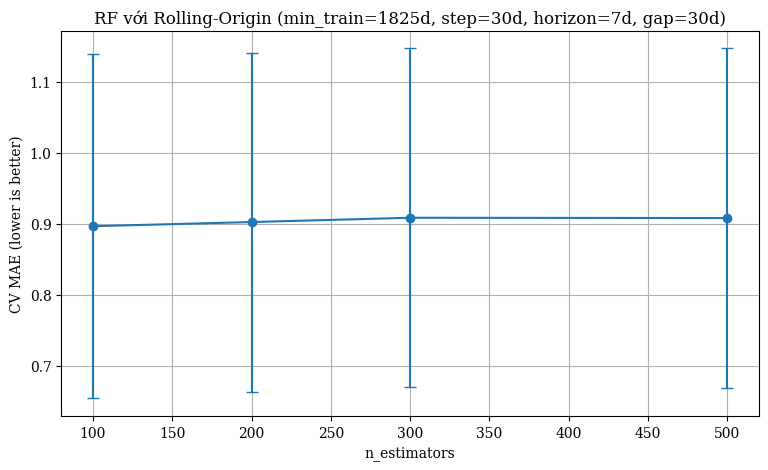

n_estimators tối ưu (Rolling-Origin CV): 100 | CV = 0.8966 ± 0.2423

Hiệu năng trên Validation:
  MAE : 0.9461
  RMSE: 1.1934
  R²  : 0.7029
[RF FE (CV+Val)] time=898.89s | Py-peak=62.6 MB | RSS(before/after/delta)=1929.0/2433.0/504.1 MB

Hiệu năng trên Test:
  MAE : 1.0002
  RMSE: 1.2982
  R²  : 0.5977
[RF FE (Test)] time=0.03s | Py-peak=1.9 MB | RSS(before/after/delta)=2433.0/2434.5/1.4 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


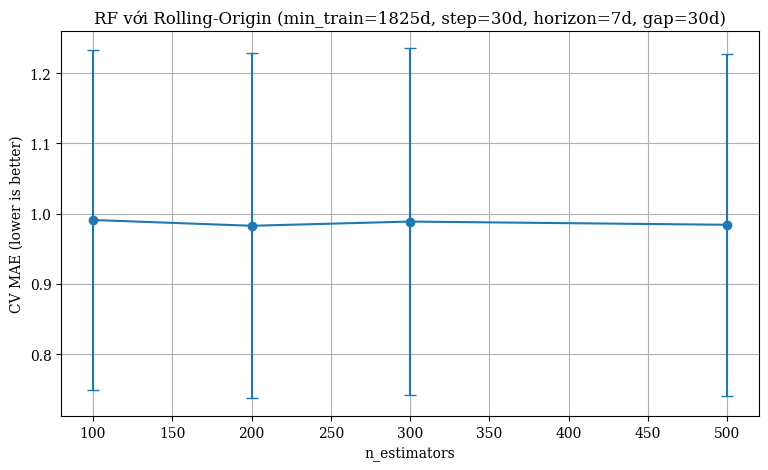

n_estimators tối ưu (Rolling-Origin CV): 200 | CV = 0.9826 ± 0.2457

Hiệu năng trên Validation:
  MAE : 0.9924
  RMSE: 1.2353
  R²  : 0.6787
[RF DT (CV+Val)] time=766.05s | Py-peak=59.5 MB | RSS(before/after/delta)=2434.5/2775.6/341.2 MB

Hiệu năng trên Test:
  MAE : 1.0136
  RMSE: 1.3195
  R²  : 0.5847
[RF DT (Test)] time=0.04s | Py-peak=1.8 MB | RSS(before/after/delta)=2775.6/2776.8/1.1 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


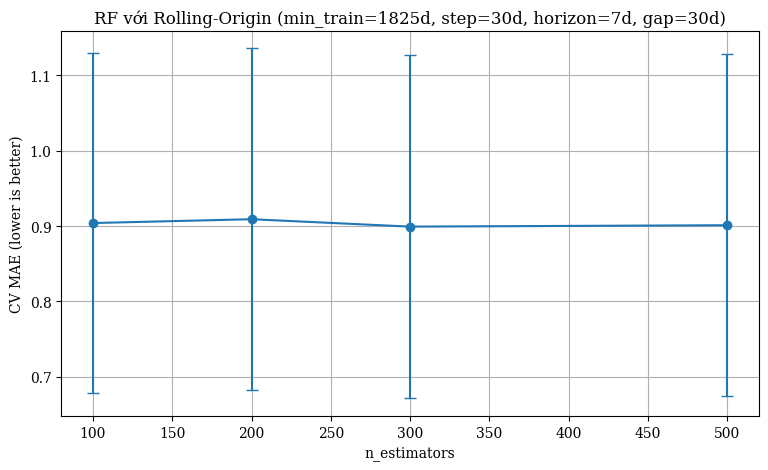

n_estimators tối ưu (Rolling-Origin CV): 300 | CV = 0.8992 ± 0.2276

Hiệu năng trên Validation:
  MAE : 0.9494
  RMSE: 1.1970
  R²  : 0.7011
[RF FE+DT (CV+Val)] time=1328.35s | Py-peak=63.5 MB | RSS(before/after/delta)=2776.8/2985.1/208.4 MB

Hiệu năng trên Test:
  MAE : 0.9936
  RMSE: 1.2871
  R²  : 0.6046
[RF FE+DT (Test)] time=0.06s | Py-peak=1.9 MB | RSS(before/after/delta)=2985.1/2986.6/1.5 MB


,run,val_mae,val_rmse,val_r2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb,test_mae,test_rmse,test_r2
0,RF Original (CV+Val),0.997141,1.237717,0.677431,844.112709,73.794774,498.703125,1926.187500,1427.484375,NaN,NaN,NaN
1,RF Original (Test),NaN,NaN,NaN,0.031706,2.383298,1926.328125,1928.968750,2.640625,1.011927,1.318428,0.585343
2,RF FE (CV+Val),0.946103,1.193392,0.702897,898.886906,62.629592,1928.968750,2433.031250,504.062500,NaN,NaN,NaN
3,RF FE (Test),NaN,NaN,NaN,0.027595,1.922760,2433.046875,2434.484375,1.437500,1.000177,1.298245,0.597710
4,RF DT (CV+Val),0.992439,1.235329,0.678675,766.052506,59.506548,2434.484375,2775.640625,341.156250,NaN,NaN,NaN
5,RF DT (Test),NaN,NaN,NaN,0.044372,1.777191,2775.640625,2776.750000,1.109375,1.013617,1.319523,0.584654
6,RF FE+DT (CV+Val),0.949420,1.196973,0.701111,1328.351789,63.483175,2776.750000,2985.125000,208.375000,NaN,NaN,NaN
7,RF FE+DT (Test),NaN,NaN,NaN,0.057943,1.881207,2985.125000,2986.593750,1.468750,0.993588,1.287057,0.604614


In [26]:
runs = []

# RF on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_rf_reg,
    X_train, y_train, g_train,     
    X_val,   y_val,
    label="RF Original (CV+Val)"
)
rf_model, rf_val_metrics, ab_info = res1
runs.append({"run": "RF Original (CV+Val)", **rf_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_model, X_test, y_test,
    label="RF Original (Test)"
)
rf_test_metrics = res1t
runs.append({"run": "RF Original (Test)", **rf_test_metrics, **stats1t})

# RF on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_rf_reg,
    X_fe_train, y_fe_train, g_fe_train,   
    X_fe_val,   y_fe_val,
    label="RF FE (CV+Val)"
)
rf_fe_model, rf_val_fe_metrics, ab_fe_info = res2
runs.append({"run": "RF FE (CV+Val)", **rf_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_fe_model, X_fe_test, y_fe_test,
    label="RF FE (Test)"
)
rf_test_fe_metrics = res2t
runs.append({"run": "RF FE (Test)", **rf_test_fe_metrics, **stats2t})

# RF on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_rf_reg,
    X_dt_train, y_dt_train, g_dt_train,   
    X_dt_val,   y_dt_val,
    label="RF DT (CV+Val)"
)
rf_dt_model, rf_val_dt_metrics, ab_dt_info = res3
runs.append({"run": "RF DT (CV+Val)", **rf_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_dt_model, X_dt_test, y_dt_test,
    label="RF DT (Test)"
)
rf_test_dt_metrics = res3t
runs.append({"run": "RF DT (Test)", **rf_test_dt_metrics, **stats3t})

# RF on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_rf_reg,
    X_fe_dt_train, y_fe_dt_train, g_fe_dt_train,  
    X_fe_dt_val,   y_fe_dt_val,
    label="RF FE+DT (CV+Val)"
)
rf_fe_dt_model, rf_val_fe_dt_metrics, ab_fe_dt_info = res4
runs.append({"run": "RF FE+DT (CV+Val)", **rf_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="RF FE+DT (Test)"
)
rf_test_fe_dt_metrics = res4t
runs.append({"run": "RF FE+DT (Test)", **rf_test_fe_dt_metrics, **stats4t})

df_runs = pd.DataFrame(runs)
display(df_runs)

## 1.4. 📈 Random Forest Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R2

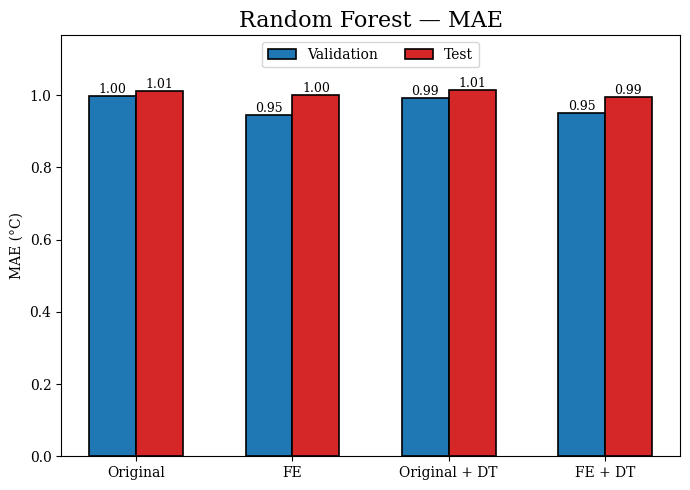

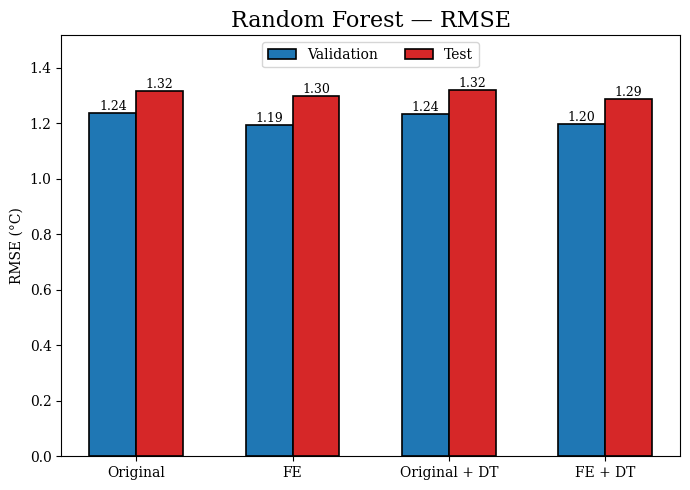

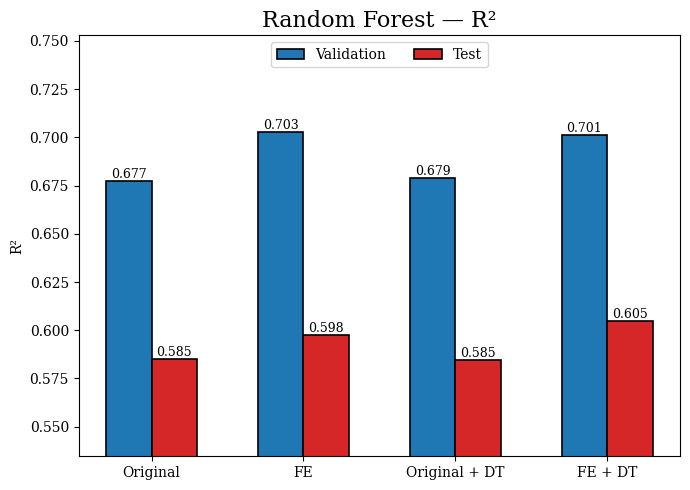

In [27]:
# MAE
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='mae'
)

# RMSE
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='rmse'
)

# R2
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='r2'
)

# **2. AdaBoost**

## 2.1. Find Optimal AdaBoost Function

In [30]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_ada_timeseries(
    X_train, y_train, groups_train,
    n_estimators_range=range(10, 101, 10),
    # Rolling-Origin params
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # Ada params
    learning_rate=0.1,
    base_max_depth=3,         
    loss="linear",
    main_metric="mae",
    plot=True,
):
    # chọn hàm đánh giá
    m = main_metric.lower().strip()
    if m == "mae":
        scorer = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)
        ylabel = "CV MAE (lower is better)"
    elif m == "rmse":
        scorer = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
        ylabel = "CV RMSE (lower is better)"
    else:
        raise ValueError("metric must be 'mae' or 'rmse'")

    # splitter theo thời gian thực
    tscv = RollingOriginTimeSeriesSplit(
        date_col=None,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
    )

    splits = list(tscv.split(X=None, groups=groups_train))

    ns = list(n_estimators_range)
    meds, stds = [], []

    for n in ns:
        fold_scores = []
        for tr_idx, va_idx in splits:
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train.iloc[tr_idx]
            y_va = y_train.iloc[va_idx]

            model = AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=base_max_depth, random_state=SEED),
                n_estimators=n,
                learning_rate=learning_rate,
                loss=loss,
                random_state=SEED,
            )
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_va)
            fold_scores.append(scorer(y_va, y_pred))

        meds.append(np.median(fold_scores))
        stds.append(np.std(fold_scores))

    # chọn n tốt nhất
    best_idx = int(np.argmin(meds))   
    best_n = ns[best_idx]

    if plot:
        plt.figure(figsize=(9, 5))
        plt.errorbar(ns, meds, yerr=stds, fmt='o-', capsize=4)
        plt.title(
            f"AdaBoost (Rolling-Origin: "
            f"min_train={min_train_days}d, step={step_days}d, "
            f"horizon={horizon_days}d, gap={gap_days}d)"
        )
        plt.xlabel("n_estimators")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

    print(
        f"n_estimators tối ưu (Rolling-Origin CV): {best_n} | "
        f"{ylabel.split()[0]} = {meds[best_idx]:.4f} ± {stds[best_idx]:.4f}"
    )

    # train lại trên toàn bộ train
    best_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=base_max_depth, random_state=SEED),
        n_estimators=best_n,
        learning_rate=learning_rate,
        loss=loss,
        random_state=SEED,
    )
    best_model.fit(X_train, y_train)

    cv_table = {
        "n_estimators": ns,
        "cv_median": meds,
        "cv_std": stds,
        "metric": m,
    }
    return best_model, best_n, cv_table

## 2.2. Evaluate Function

In [ ]:
def evaluate_val_ada_reg(
    X_train, y_train, groups_train,    
    X_val,   y_val,
    n_estimators_range=range(10, 101, 10),
    # params cho Rolling-Origin
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # params cho AdaBoost
    learning_rate=0.1,
    base_max_depth=3,
    loss='linear',        # {'linear','square','exponential'}
    main_metric='mae',    
    plot=True
):
    print("Tìm n_estimators tối ưu cho Ada Boosting Regressor (Rolling-Origin-TimeSeriesSplit)")
    best_model, best_n, cv_table = find_optimal_ada_timeseries(
        X_train, y_train, groups_train,
        n_estimators_range=n_estimators_range,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
        learning_rate=learning_rate,
        base_max_depth=base_max_depth,
        loss=loss,
        main_metric=main_metric,
        plot=plot,
    )

    # Đánh giá trên validation
    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print("\nHiệu năng AdaBoostRegressor trên tập validation:")
    print(f"- MAE : {val_mae:.4f}")
    print(f"- RMSE: {val_rmse:.4f}")
    print(f"- R2  : {val_r2:.4f}")

    val_metrics = {"MAE": val_mae, "RMSE": val_rmse, "R2": val_r2}

    info = {
        "n_estimators": best_n,
        "cv_metric": main_metric.lower(),
        "cv_table": cv_table,               # chứa median/std từng n
        "cv_config": {
            "min_train_days": min_train_days,
            "step_days": step_days,
            "horizon_days": horizon_days,
            "gap_days": gap_days,
            "max_splits": max_splits,
        },
        "ada_params": {
            "learning_rate": learning_rate,
            "base_max_depth": base_max_depth,
            "loss": loss,
        }
    }
    return best_model, val_metrics, info


def evaluate_test_ada_reg(model, X_test, y_test):

    test_pred = model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print("\nHiệu năng trên Test:")
    print(f"- MAE : {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R2  : {test_r2:.4f}")

    return {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

## 2.3. 4-Way Evaluation of AdaBoost
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

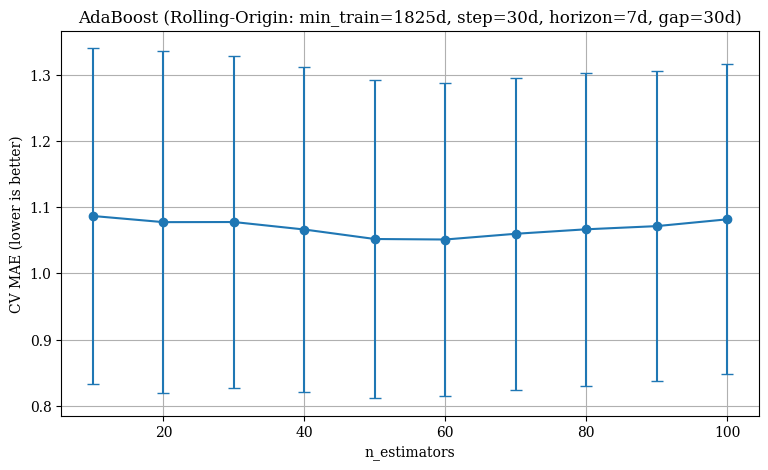

n_estimators tối ưu (Rolling-Origin CV): 60 | CV = 1.0513 ± 0.2370

Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.2987
- RMSE: 1.5672
- R²  : 0.4828
[AB Original (CV+Val)] time=2304.29s | Py-peak=66.4 MB | RSS(before/after/delta)=2257.0/1411.9/-845.1 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.1248
- RMSE: 1.4376
- R²  : 0.5070
[AB Original (Test)] time=0.02s | Py-peak=12.3 MB | RSS(before/after/delta)=1413.2/1427.7/14.5 MB


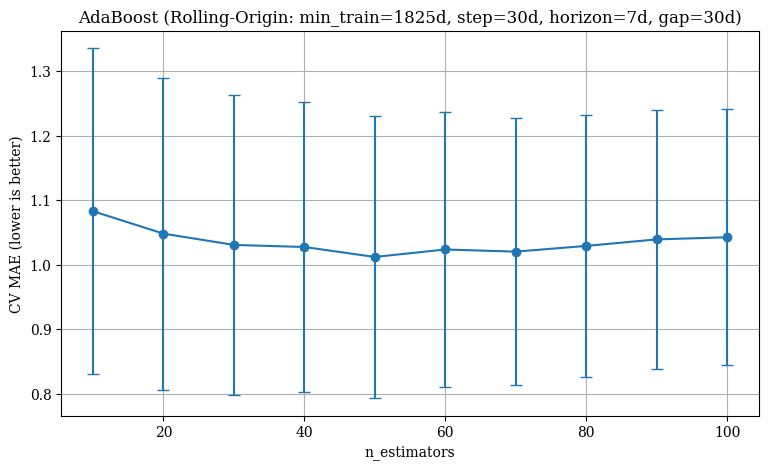

n_estimators tối ưu (Rolling-Origin CV): 50 | CV = 1.0121 ± 0.2193

Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.1175
- RMSE: 1.3836
- R²  : 0.6006
[AB FE (CV+Val)] time=2612.27s | Py-peak=60.8 MB | RSS(before/after/delta)=1427.7/763.1/-664.6 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.0886
- RMSE: 1.3810
- R²  : 0.5448
[AB FE (Test)] time=0.02s | Py-peak=11.3 MB | RSS(before/after/delta)=859.7/861.0/1.3 MB


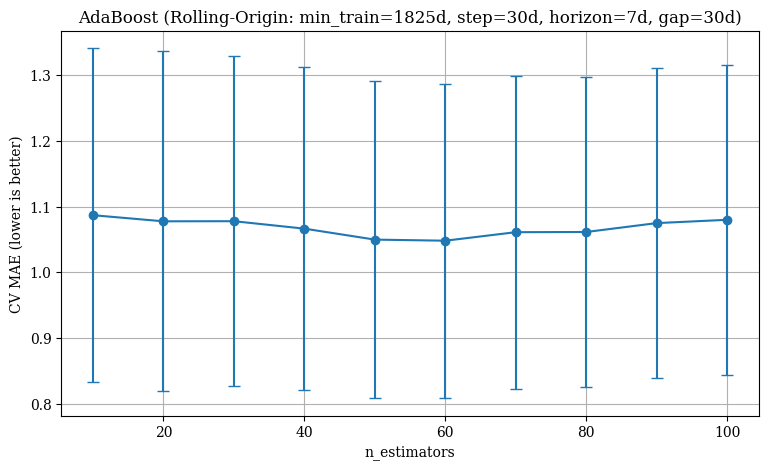

n_estimators tối ưu (Rolling-Origin CV): 60 | CV = 1.0481 ± 0.2385

Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.2970
- RMSE: 1.5662
- R²  : 0.4835
[AB DT (CV+Val)] time=2084.50s | Py-peak=44.3 MB | RSS(before/after/delta)=861.0/840.1/-20.9 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.1230
- RMSE: 1.4361
- R²  : 0.5080
[AB DT (Test)] time=0.02s | Py-peak=12.3 MB | RSS(before/after/delta)=842.0/844.8/2.8 MB


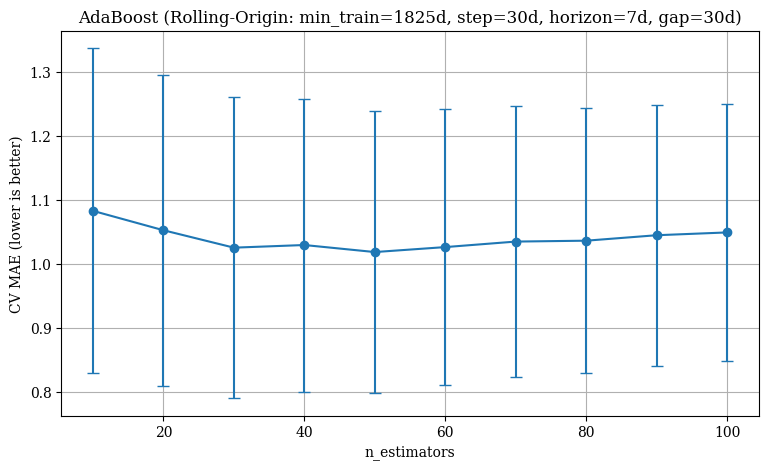

n_estimators tối ưu (Rolling-Origin CV): 50 | CV = 1.0187 ± 0.2196

Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.1265
- RMSE: 1.3908
- R²  : 0.5965
[AB FE+DT (CV+Val)] time=2882.59s | Py-peak=50.6 MB | RSS(before/after/delta)=844.8/624.2/-220.6 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.0838
- RMSE: 1.3776
- R²  : 0.5470
[AB FE+DT (Test)] time=0.02s | Py-peak=10.1 MB | RSS(before/after/delta)=723.3/725.9/2.6 MB


,run,mae,rmse,r2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,AB Original (CV+Val),1.298713,1.567223,0.482821,2304.293928,66.363811,2256.984375,1411.890625,-845.093750
1,AB Original (Test),1.124838,1.437553,0.507027,0.020610,12.293351,1413.203125,1427.656250,14.453125
2,AB FE (CV+Val),1.117519,1.383617,0.600633,2612.272445,60.801171,1427.656250,763.093750,-664.562500
3,AB FE (Test),1.088584,1.381022,0.544774,0.017015,11.320113,859.687500,861.000000,1.312500
4,AB DT (CV+Val),1.297038,1.566223,0.483480,2084.504949,44.268522,861.000000,840.078125,-20.921875
5,AB DT (Test),1.122961,1.436092,0.508028,0.018237,12.293218,842.015625,844.765625,2.750000
6,AB FE+DT (CV+Val),1.126500,1.390753,0.596502,2882.592951,50.581609,844.765625,624.203125,-220.562500
7,AB FE+DT (Test),1.083776,1.377583,0.547038,0.017020,10.092864,723.343750,725.921875,2.578125


In [32]:
runs_ab = []

# AB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_ada_reg,
    X_train, y_train, g_train,       
    X_val,   y_val,
    label="AB Original (CV+Val)"
)
ab_model, ab_val_metrics, ab_info = res1
runs_ab.append({"run": "AB Original (CV+Val)", **ab_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_model, X_test, y_test,
    label="AB Original (Test)"
)
ab_test_metrics = res1t
runs_ab.append({"run": "AB Original (Test)", **ab_test_metrics, **stats1t})

# AB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_ada_reg,
    X_fe_train, y_fe_train, g_fe_train,    
    X_fe_val,   y_fe_val,
    label="AB FE (CV+Val)"
)
ab_fe_model, ab_val_fe_metrics, ab_fe_info = res2
runs_ab.append({"run": "AB FE (CV+Val)", **ab_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_fe_model, X_fe_test, y_fe_test,
    label="AB FE (Test)"
)
ab_test_fe_metrics = res2t
runs_ab.append({"run": "AB FE (Test)", **ab_test_fe_metrics, **stats2t})

# AB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_ada_reg,
    X_dt_train, y_dt_train, g_dt_train,   
    X_dt_val,   y_dt_val,
    label="AB DT (CV+Val)"
)
ab_dt_model, ab_val_dt_metrics, ab_dt_info = res3
runs_ab.append({"run": "AB DT (CV+Val)", **ab_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_dt_model, X_dt_test, y_dt_test,
    label="AB DT (Test)"
)
ab_test_dt_metrics = res3t
runs_ab.append({"run": "AB DT (Test)", **ab_test_dt_metrics, **stats3t})

# AB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_ada_reg,
    X_fe_dt_train, y_fe_dt_train, g_fe_dt_train,    
    X_fe_dt_val,   y_fe_dt_val,
    label="AB FE+DT (CV+Val)"
)
ab_fe_dt_model, ab_val_fe_dt_metrics, ab_fe_dt_info = res4
runs_ab.append({"run": "AB FE+DT (CV+Val)", **ab_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="AB FE+DT (Test)"
)
ab_test_fe_dt_metrics = res4t
runs_ab.append({"run": "AB FE+DT (Test)", **ab_test_fe_dt_metrics, **stats4t})

# DataFrame kết quả cho AB
df_runs_ab = pd.DataFrame(runs_ab)
display(df_runs_ab)

## 2.4. 📈 Ada Boost Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R2

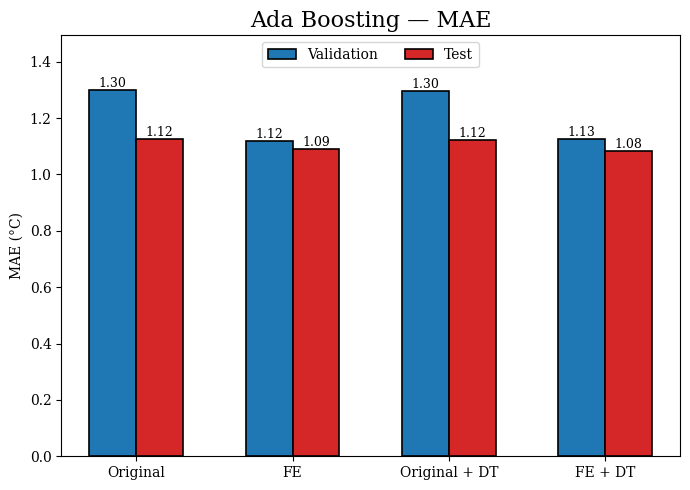

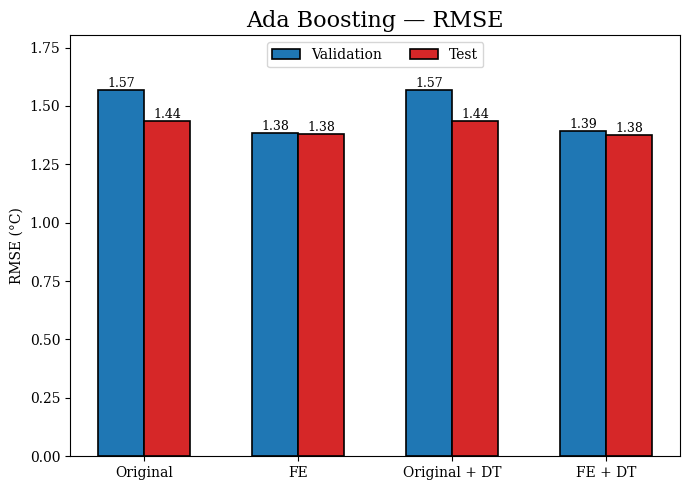

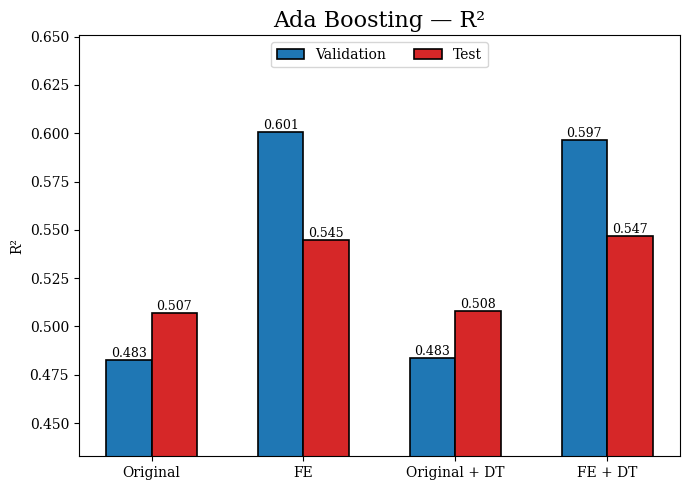

In [33]:
# MAE
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='mae'
)

# RMSE
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='rmse'
)

# R2
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='r2'
)

# **3. Gradient Boosting**

## 3.1. Find Optimal GB Function

In [34]:
def find_optimal_gb_timeseries(
    X_train, y_train, groups_train,
    n_estimators_range=range(50, 501, 50),
    # tham số Rolling-Origin
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # tham số GB
    metric="mae",         
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42,
    plot=True,
):
    """
    Tìm n_estimators tối ưu cho GradientBoostingRegressor
    bằng Rolling-Origin CV theo datetime (groups_train).
    Trả về: best_model, best_n, cv_table
    """
    # chọn hàm đánh giá
    m = metric.lower().strip()
    if m == "mae":
        scorer = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)
        ylabel = "CV MAE (lower is better)"
    elif m == "rmse":
        scorer = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
        ylabel = "CV RMSE (lower is better)"
    else:
        raise ValueError("metric must be 'mae' or 'rmse'")

    # splitter theo thời gian thực
    tscv = RollingOriginTimeSeriesSplit(
        date_col=None,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
    )

    folds = list(tscv.split(X=None, groups=groups_train))
    ns = list(n_estimators_range)
    meds, stds = [], []

    # CV trên từng n_estimators
    for n in ns:
        fold_scores = []

        for tr_idx, va_idx in folds:
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train.iloc[tr_idx]
            y_va = y_train.iloc[va_idx]

            gb = GradientBoostingRegressor(
                n_estimators=n,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=random_state,
            )
            gb.fit(X_tr, y_tr)
            pred = gb.predict(X_va)
            fold_scores.append(scorer(y_va, pred))

        # median để chống 1 fold xấu
        meds.append(np.median(fold_scores))
        stds.append(np.std(fold_scores))

    best_idx = int(np.argmin(meds))  # mae/rmse: lower is better
    best_n = ns[best_idx]

    print(
        f"[GB][Rolling-Origin] Best n_estimators = {best_n} | "
        f"{ylabel.split()[0]} = {meds[best_idx]:.4f} ± {stds[best_idx]:.4f}"
    )

    if plot:
        plt.figure(figsize=(8, 5))
        plt.errorbar(ns, meds, yerr=stds, fmt="o-", capsize=4)
        plt.title(
            f"Tối ưu n_estimators cho GradientBoosting "
            f"(min={min_train_days}d, step={step_days}d, "
            f"horizon={horizon_days}d, gap={gap_days}d)"
        )
        plt.xlabel("n_estimators")
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # huấn luyện lại mô hình tốt nhất trên toàn bộ train
    best_model = GradientBoostingRegressor(
        n_estimators=best_n,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=random_state,
    )
    best_model.fit(X_train, y_train)

    cv_table = {
        "n_estimators": ns,
        "cv_median": meds,
        "cv_std": stds,
        "metric": m,
    }
    return best_model, best_n, cv_table

## 3.2. Evaluation Function

In [ ]:
def evaluate_val_gb_reg(
    X_train, y_train, groups_train,
    X_val,   y_val,
    n_estimators_range=range(50, 501, 50),
    # params Rolling-Origin
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # params GB
    metric="mae",
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=SEED,
    plot=True,
):
    print("Tìm n_estimators tối ưu cho Gradient Boosting Regressor (Rolling-Origin-TimeSeriesSplit)")

    gb_model, best_n, cv_table = find_optimal_gb_timeseries(
        X_train, y_train, groups_train,
        n_estimators_range=n_estimators_range,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
        metric=metric,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=random_state,
        plot=plot,
    )

    # Đánh giá trên validation
    val_pred = gb_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print("\nHiệu năng trên Validation:")
    print(f"- MAE : {val_mae:.4f}")
    print(f"- RMSE: {val_rmse:.4f}")
    print(f"- R2  : {val_r2:.4f}")

    val_metrics = {"MAE": val_mae, "RMSE": val_rmse, "R2": val_r2}
    info = {
        "n_estimators": best_n,
        "cv": cv_table,
        "cv_config": {
            "min_train_days": min_train_days,
            "step_days": step_days,
            "horizon_days": horizon_days,
            "gap_days": gap_days,
            "max_splits": max_splits,
        },
        "gb_params": {
            "learning_rate": learning_rate,
            "max_depth": max_depth,
            "subsample": subsample,
        },
    }
    return gb_model, val_metrics, info


def evaluate_test_gb_reg(gb_model, X_test, y_test):

    test_pred = gb_model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print("\nHiệu năng trên Test:")
    print(f"- MAE : {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R2  : {test_r2:.4f}")

    return {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

## 3.3. 4-Way Evaluation of GradientBoosting

Tìm n_estimators tối ưu cho Gradient Boosting Regressor (Rolling-Origin-TimeSeriesSplit)
[GB][Rolling-Origin] Best n_estimators = 50 | CV = 0.9499 ± 0.2495


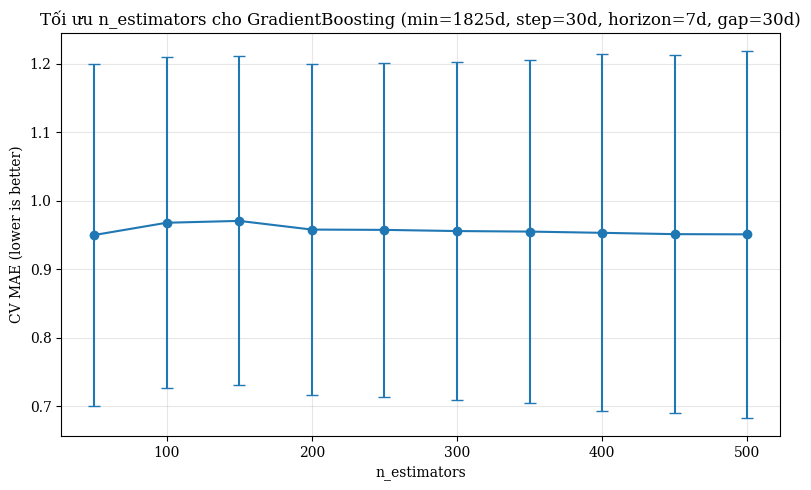


Hiệu năng trên Validation:
- MAE : 1.0540
- RMSE: 1.2929
- R²  : 0.6480
[GB Original (CV+Val)] time=10455.97s | Py-peak=102.0 MB | RSS(before/after/delta)=590.8/915.9/325.1 MB

Hiệu năng trên Test:
- MAE : 1.0215
- RMSE: 1.3238
- R²  : 0.5819
[GB Original (Test)] time=0.00s | Py-peak=2.0 MB | RSS(before/after/delta)=920.0/924.2/4.1 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (Rolling-Origin-TimeSeriesSplit)
[GB][Rolling-Origin] Best n_estimators = 50 | CV = 0.8978 ± 0.2308


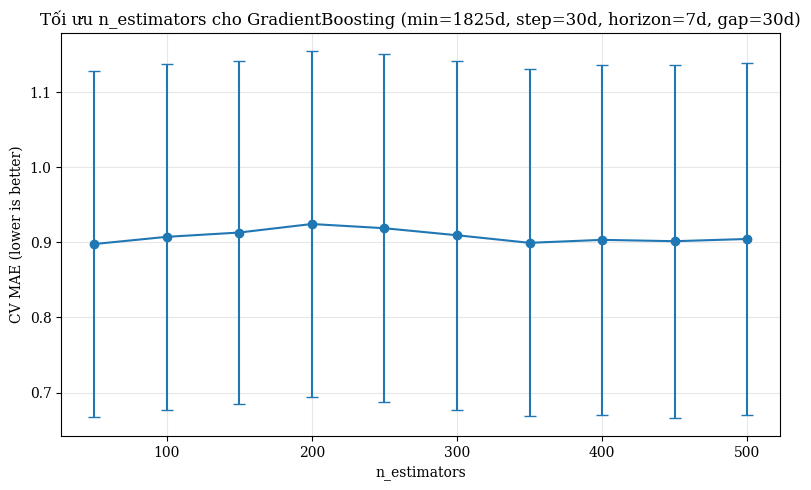


Hiệu năng trên Validation:
- MAE : 0.9734
- RMSE: 1.2207
- R²  : 0.6891
[GB FE (CV+Val)] time=12725.03s | Py-peak=47.5 MB | RSS(before/after/delta)=924.2/1061.5/137.4 MB

Hiệu năng trên Test:
- MAE : 1.0033
- RMSE: 1.3008
- R²  : 0.5961
[GB FE (Test)] time=0.00s | Py-peak=1.8 MB | RSS(before/after/delta)=1061.5/1062.9/1.3 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (Rolling-Origin-TimeSeriesSplit)
[GB][Rolling-Origin] Best n_estimators = 50 | CV = 0.9613 ± 0.2466


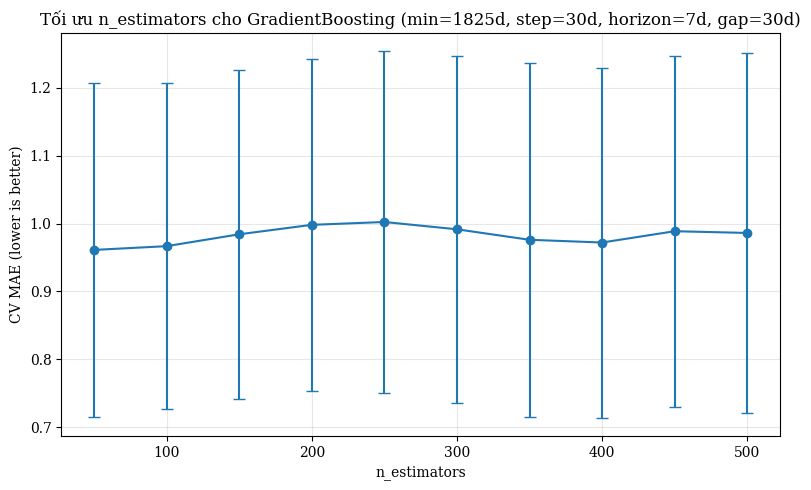


Hiệu năng trên Validation:
- MAE : 1.0533
- RMSE: 1.2936
- R²  : 0.6477
[GB DT (CV+Val)] time=9722.81s | Py-peak=37.3 MB | RSS(before/after/delta)=1062.9/962.6/-100.3 MB

Hiệu năng trên Test:
- MAE : 1.0285
- RMSE: 1.3303
- R²  : 0.5778
[GB DT (Test)] time=0.00s | Py-peak=1.0 MB | RSS(before/after/delta)=962.6/963.7/1.1 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (Rolling-Origin-TimeSeriesSplit)
[GB][Rolling-Origin] Best n_estimators = 100 | CV = 0.9227 ± 0.2225


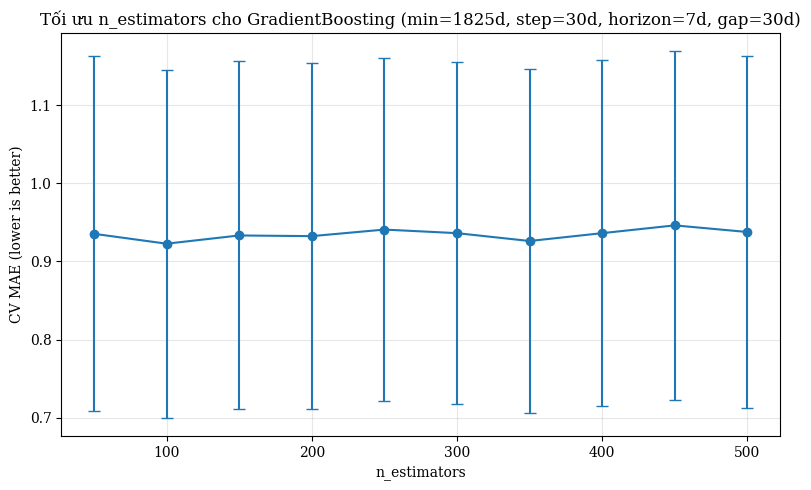


Hiệu năng trên Validation:
- MAE : 0.9414
- RMSE: 1.1902
- R²  : 0.7045
[GB FE+DT (CV+Val)] time=13914.18s | Py-peak=42.2 MB | RSS(before/after/delta)=963.7/977.5/13.8 MB

Hiệu năng trên Test:
- MAE : 0.9896
- RMSE: 1.2803
- R²  : 0.6087
[GB FE+DT (Test)] time=0.01s | Py-peak=1.3 MB | RSS(before/after/delta)=977.5/978.8/1.3 MB


,run,MAE,RMSE,R2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,GB Original (CV+Val),1.054037,1.292894,0.648030,10455.972439,101.968056,590.843750,915.906250,325.062500
1,GB Original (Test),1.021513,1.323843,0.581930,0.004742,2.009520,920.046875,924.156250,4.109375
2,GB FE (CV+Val),0.973399,1.220699,0.689145,12725.033533,47.500725,924.156250,1061.546875,137.390625
3,GB FE (Test),1.003344,1.300812,0.596118,0.004463,1.847944,1061.546875,1062.859375,1.312500
4,GB DT (CV+Val),1.053279,1.293567,0.647663,9722.812019,37.286428,1062.859375,962.562500,-100.296875
5,GB DT (Test),1.028539,1.330310,0.577835,0.004126,1.006643,962.625000,963.703125,1.078125
6,GB FE+DT (CV+Val),0.941358,1.190194,0.704487,13914.179782,42.233654,963.703125,977.484375,13.781250
7,GB FE+DT (Test),0.989594,1.280318,0.608743,0.005489,1.282064,977.484375,978.828125,1.343750


In [39]:
runs_gb = []

# GB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_gb_reg,
    X_train, y_train, g_train,      
    X_val,   y_val,
    label="GB Original (CV+Val)"
)
gb_model, gb_val_metrics, gb_info = res1
runs_gb.append({"run": "GB Original (CV+Val)", **gb_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_model, X_test, y_test,
    label="GB Original (Test)"
)
gb_test_metrics = res1t
runs_gb.append({"run": "GB Original (Test)", **gb_test_metrics, **stats1t})


# GB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_gb_reg,
    X_fe_train, y_fe_train, g_fe_train,     
    X_fe_val,   y_fe_val,
    label="GB FE (CV+Val)"
)
gb_fe_model, gb_val_fe_metrics, gb_fe_info = res2
runs_gb.append({"run": "GB FE (CV+Val)", **gb_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_fe_model, X_fe_test, y_fe_test,
    label="GB FE (Test)"
)
gb_test_fe_metrics = res2t
runs_gb.append({"run": "GB FE (Test)", **gb_test_fe_metrics, **stats2t})


# GB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_gb_reg,
    X_dt_train, y_dt_train, g_dt_train,     
    X_dt_val,   y_dt_val,
    label="GB DT (CV+Val)"
)
gb_dt_model, gb_val_dt_metrics, gb_dt_info = res3
runs_gb.append({"run": "GB DT (CV+Val)", **gb_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_dt_model, X_dt_test, y_dt_test,
    label="GB DT (Test)"
)
gb_test_dt_metrics = res3t
runs_gb.append({"run": "GB DT (Test)", **gb_test_dt_metrics, **stats3t})


# GB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_gb_reg,
    X_fe_dt_train, y_fe_dt_train, g_fe_dt_train,     
    X_fe_dt_val,   y_fe_dt_val,
    label="GB FE+DT (CV+Val)"
)
gb_fe_dt_model, gb_val_fe_dt_metrics, gb_fe_dt_info = res4
runs_gb.append({"run": "GB FE+DT (CV+Val)", **gb_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="GB FE+DT (Test)"
)
gb_test_fe_dt_metrics = res4t
runs_gb.append({"run": "GB FE+DT (Test)", **gb_test_fe_dt_metrics, **stats4t})

# DataFrame kết quả cho GB
df_runs_gb = pd.DataFrame(runs_gb)
display(df_runs_gb)

## 3.4. 📈 Gradient Boosting Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R2

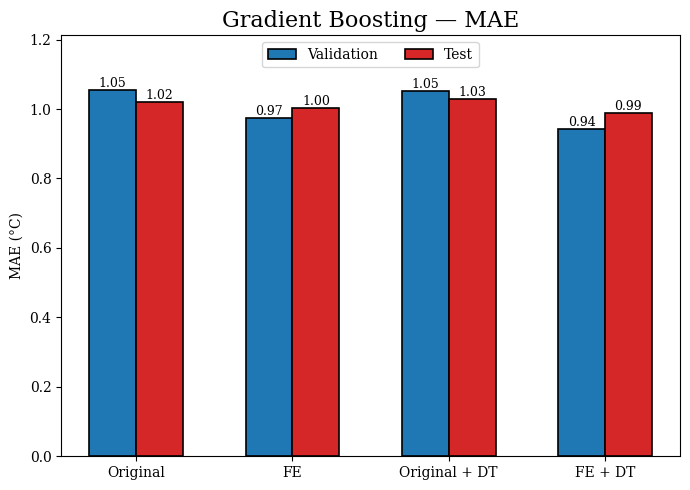

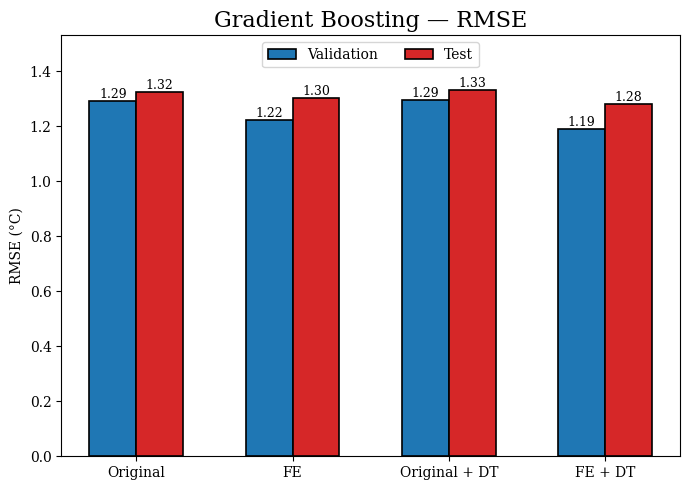

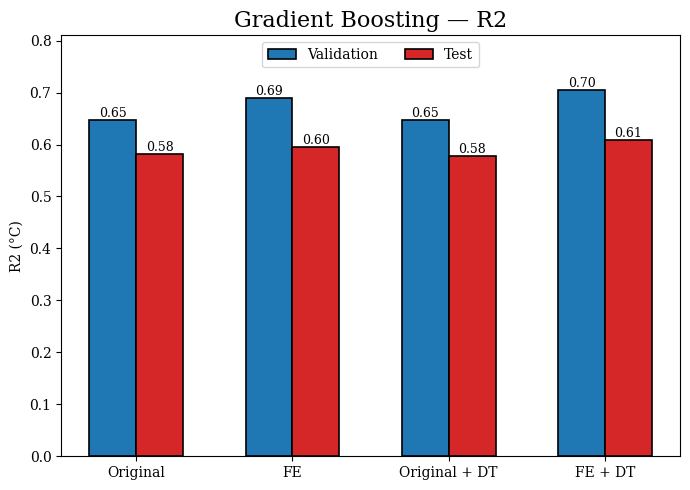

In [40]:
# MAE
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='MAE'
)

# RMSE
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='RMSE'
)

# R2
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='R2'
)

# **4. XGBoost**

## 4.1. Find Optimal XGB Function

In [59]:
def find_optimal_xgb_reg(
    X_train, y_train, groups_train,
    # nếu là int -> Manual ES; nếu là iterable -> sweep
    n_estimators_range=5000,
    # params cho rolling-origin
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # params XGBoost
    main_metric='MAE',          # 'MAE', 'RMSE', 'R2'
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    use_gpu=False,
    plot=True,
):
    """
    XGBoost + Rolling-Origin CV (theo datetime):
      - nếu n_estimators_range là int -> Mode A (manual early-stopping)
      - nếu là iterable -> Mode B (sweep)
    Trả về: best_model, best_n, best_score, info_dict
    """

    # chuẩn hóa metric
    m = main_metric.upper().strip()
    if m not in {'MAE', 'RMSE', 'R2'}:
        raise ValueError("main_metric must be one of {'MAE','RMSE','R2'}")

    # splitter theo thời gian thực
    ro_cv = RollingOriginTimeSeriesSplit(
        date_col=None,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
    )
    # tính trước các folds để tái sử dụng cho mọi n
    folds = list(ro_cv.split(X=None, groups=groups_train))

    tree_method = 'gpu_hist' if use_gpu else 'hist'
    base_kwargs = dict(
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        objective='reg:squarederror',
        random_state=SEED,
        n_jobs=-1,
        tree_method=tree_method,
        verbosity=0,
    )

    # MODE A: MANUAL EARLY STOP
    if isinstance(n_estimators_range, int):
        max_estimators = int(n_estimators_range)
        fold_best_n = []
        fold_mae, fold_rmse, fold_r2 = [], [], []

        print(">>> [XGB][Rolling-Origin] Manual-ES mode")

        for fold_idx, (tr_idx, va_idx) in enumerate(folds, start=1):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            # XGB eval_metric phải là tên thấp hơn (mae/rmse)
            es_metric = 'mae' if m == 'MAE' else 'rmse'

            model = XGBRegressor(
                n_estimators=max_estimators,
                eval_metric=es_metric,
                **base_kwargs
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

            # lấy đường cong
            res = model.evals_result()
            metric_curve = res['validation_0'][es_metric]
            best_iter = int(np.argmin(metric_curve))
            fold_best_n.append(best_iter + 1)

            # vẽ cho fold đầu
            if plot and fold_idx == 1:
                plt.figure(figsize=(8, 5))
                plt.plot(metric_curve, label=f'Fold {fold_idx} - val {es_metric.upper()}')
                plt.axvline(best_iter, color='r', linestyle='--', label='Best Iter')
                plt.xlabel('Epoch')
                plt.ylabel(es_metric.upper())
                plt.title('XGB Manual-ES — Fold 1')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()

            # predict ở best_iter
            y_hat = model.predict(X_va, iteration_range=(0, best_iter + 1))
            mae = mean_absolute_error(y_va, y_hat)
            rmse = np.sqrt(mean_squared_error(y_va, y_hat))
            r2 = r2_score(y_va, y_hat)
            fold_mae.append(mae)
            fold_rmse.append(rmse)
            fold_r2.append(r2)

        # dùng median để chống 1 fold xấu
        val_mae = float(np.median(fold_mae))
        val_rmse = float(np.median(fold_rmse))
        val_r2 = float(np.median(fold_r2))
        best_n = int(np.median(fold_best_n))

        print(f"[XGB][Manual-ES][Rolling] best_n≈{best_n} | "
              f"MAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R2={val_r2:.4f}")

        # train lại model cuối
        final_model = XGBRegressor(
            n_estimators=best_n,
            eval_metric='mae' if m == 'MAE' else 'rmse',
            **base_kwargs
        )
        final_model.fit(X_train, y_train, verbose=False)

        chosen_score = (
            val_mae if m == 'MAE'
            else val_rmse if m == 'RMSE'
            else val_r2
        )

        info = {
            'mode': 'manual_es',
            'fold_best_n': fold_best_n,
            'fold_mae': fold_mae,
            'fold_rmse': fold_rmse,
            'fold_r2': fold_r2,
            'cv_config': {
                'min_train_days': min_train_days,
                'step_days': step_days,
                'horizon_days': horizon_days,
                'gap_days': gap_days,
                'max_splits': max_splits,
            },
        }
        return final_model, best_n, chosen_score, info

    # MODE B: SWEEP    
    n_list = list(n_estimators_range)
    all_mae, all_rmse, all_r2 = [], [], []

    print(">>> [XGB][Rolling-Origin] Sweep mode")

    for n in n_list:
        f_mae, f_rmse, f_r2 = [], [], []
        for tr_idx, va_idx in folds:
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            model = XGBRegressor(
                n_estimators=int(n),
                **base_kwargs
            )
            model.fit(X_tr, y_tr, verbose=False)
            y_hat = model.predict(X_va)

            mae = mean_absolute_error(y_va, y_hat)
            rmse = np.sqrt(mean_squared_error(y_va, y_hat))
            r2 = r2_score(y_va, y_hat)

            f_mae.append(mae); f_rmse.append(rmse); f_r2.append(r2)

        # dùng median cho stability
        all_mae.append(float(np.median(f_mae)))
        all_rmse.append(float(np.median(f_rmse)))
        all_r2.append(float(np.median(f_r2)))

    # chọn theo metric chính
    if m == 'MAE':
        best_idx, scores, ylabel = int(np.argmin(all_mae)), all_mae, 'MAE (↓)'
    elif m == 'RMSE':
        best_idx, scores, ylabel = int(np.argmin(all_rmse)), all_rmse, 'RMSE (↓)'
    else:
        best_idx, scores, ylabel = int(np.argmax(all_r2)), all_r2, 'R2 (↑)'

    best_n = int(n_list[best_idx])
    print(f"[XGB][Sweep][Rolling] best_n={best_n} | {m}={scores[best_idx]:.4f}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(n_list, scores, 'o-', linewidth=2)
        plt.xlabel('n_estimators')
        plt.ylabel(ylabel)
        plt.title(f'XGB Rolling-Origin — chọn n_estimators theo {m}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    best_model = XGBRegressor(
        n_estimators=best_n,
        **base_kwargs
    )
    best_model.fit(X_train, y_train, verbose=False)

    info = {
        'mode': 'sweep',
        'n_estimators': n_list,
        'mae': all_mae,
        'rmse': all_rmse,
        'r2': all_r2,
        'cv_config': {
            'min_train_days': min_train_days,
            'step_days': step_days,
            'horizon_days': horizon_days,
            'gap_days': gap_days,
            'max_splits': max_splits,
        },
    }
    return best_model, best_n, scores[best_idx], info

## 4.2. Evaluation Function 

In [ ]:
def evaluate_val_xgb_reg(
    X_train, y_train, groups_train,
    X_val,   y_val,
    # XGB rolling-origin params
    n_estimators_range=5000,    # int -> manual ES, iterable -> sweep
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    # XGB params
    main_metric='MAE',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    use_gpu=False,
    plot=True,
):

    print("Tìm n_estimators tối ưu cho XGBRegressor (Rolling-Origin-TimeSeriesSplit)")

    best_model, best_n, cv_best_score, cv_info = find_optimal_xgb_reg(
        X_train, y_train, groups_train,
        n_estimators_range=n_estimators_range,
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
        main_metric=main_metric,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        use_gpu=use_gpu,
        plot=plot,
    )

    # Đánh giá trên validation hold-out
    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print("\nHiệu năng trên Validation:")
    print(f"- MAE : {val_mae:.4f}")
    print(f"- RMSE: {val_rmse:.4f}")
    print(f"- R2  : {val_r2:.4f}")

    val_metrics = {"MAE": val_mae, "RMSE": val_rmse, "R2": val_r2}

    info = {
        "n_estimators": best_n,
        "cv_best_score": cv_best_score,
        "cv_info": cv_info,
        "cv_config": {
            "min_train_days": min_train_days,
            "step_days": step_days,
            "horizon_days": horizon_days,
            "gap_days": gap_days,
            "max_splits": max_splits,
        },
        "xgb_params": {
            "learning_rate": learning_rate,
            "max_depth": max_depth,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "reg_lambda": reg_lambda,
            "min_child_weight": min_child_weight,
            "use_gpu": use_gpu,
        },
    }

    return best_model, val_metrics, info


def evaluate_test_xgb_reg(model, X_test, y_test):
    test_pred = model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print("\nHiệu năng trên Test:")
    print(f"- MAE : {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R2  : {test_r2:.4f}")

    return {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

## 4.3. 4-Way Evaluation of XGBoost
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

Tìm n_estimators tối ưu cho XGBRegressor (Rolling-Origin-TimeSeriesSplit)
>>> [XGB][Rolling-Origin] Manual-ES mode


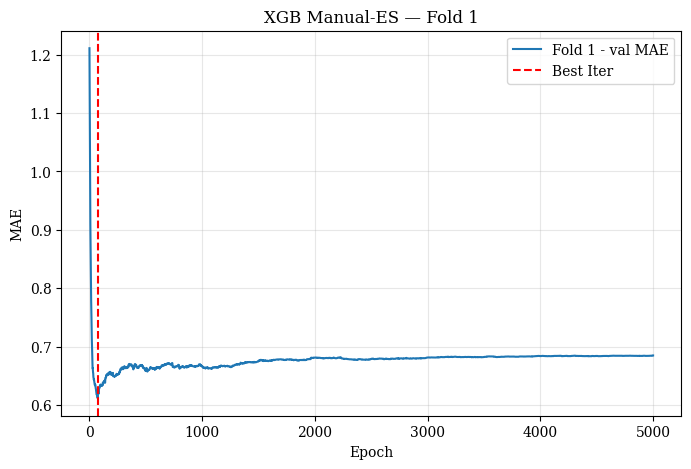

[XGB][Manual-ES][Rolling] best_n≈134 | MAE=0.8955 | RMSE=1.0967 | R2=0.3889
Validation: MAE=0.9885 | RMSE=1.2208 | R2=0.6862
[XGB Original (CV+Val)] time=805.86s | Py-peak=57.7 MB | RSS(before/after/delta)=788.7/1048.1/259.5 MB

Hiệu năng trên Test:
- MAE : 0.9875
- RMSE: 1.2845
- R2  : 0.6064
[XGB Original (Test)] time=0.01s | Py-peak=0.3 MB | RSS(before/after/delta)=1048.4/1050.5/2.1 MB
Tìm n_estimators tối ưu cho XGBRegressor (Rolling-Origin-TimeSeriesSplit)
>>> [XGB][Rolling-Origin] Manual-ES mode


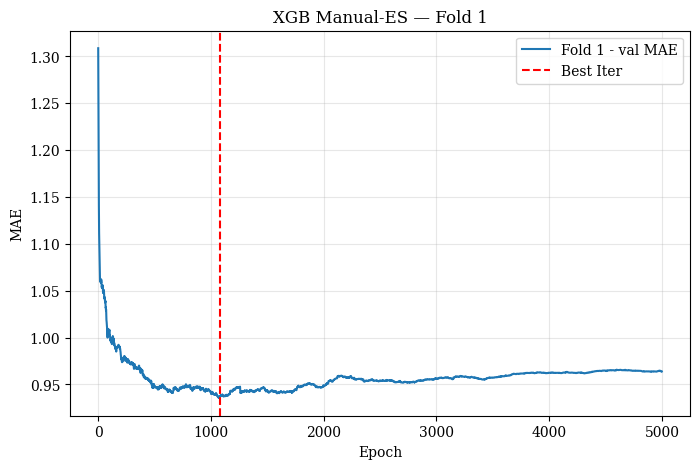

[XGB][Manual-ES][Rolling] best_n≈139 | MAE=0.8527 | RMSE=1.0981 | R2=0.3858
Validation: MAE=0.9312 | RMSE=1.1750 | R2=0.7120
[XGB FE (CV+Val)] time=652.84s | Py-peak=42.1 MB | RSS(before/after/delta)=1050.5/786.7/-263.8 MB

Hiệu năng trên Test:
- MAE : 0.9910
- RMSE: 1.2896
- R2  : 0.6030
[XGB FE (Test)] time=0.01s | Py-peak=0.2 MB | RSS(before/after/delta)=910.2/911.5/1.3 MB
Tìm n_estimators tối ưu cho XGBRegressor (Rolling-Origin-TimeSeriesSplit)
>>> [XGB][Rolling-Origin] Manual-ES mode


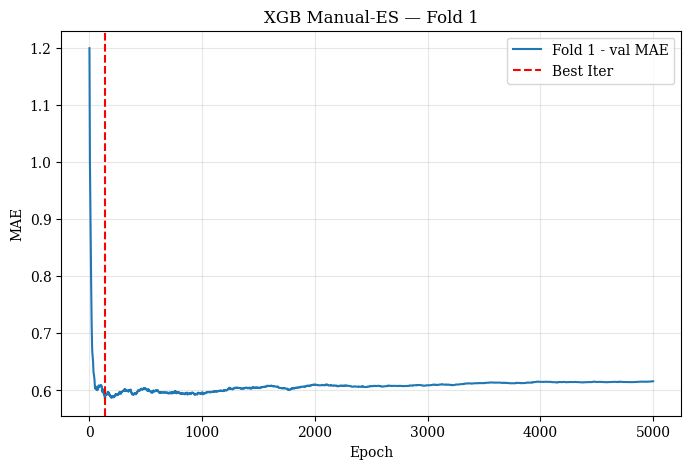

[XGB][Manual-ES][Rolling] best_n≈139 | MAE=0.9084 | RMSE=1.1794 | R2=0.3635
Validation: MAE=0.9744 | RMSE=1.2136 | R2=0.6899
[XGB DT (CV+Val)] time=628.44s | Py-peak=37.8 MB | RSS(before/after/delta)=911.5/1016.0/104.5 MB

Hiệu năng trên Test:
- MAE : 0.9987
- RMSE: 1.3046
- R2  : 0.5940
[XGB DT (Test)] time=0.01s | Py-peak=0.2 MB | RSS(before/after/delta)=1016.0/1017.0/1.1 MB
Tìm n_estimators tối ưu cho XGBRegressor (Rolling-Origin-TimeSeriesSplit)
>>> [XGB][Rolling-Origin] Manual-ES mode


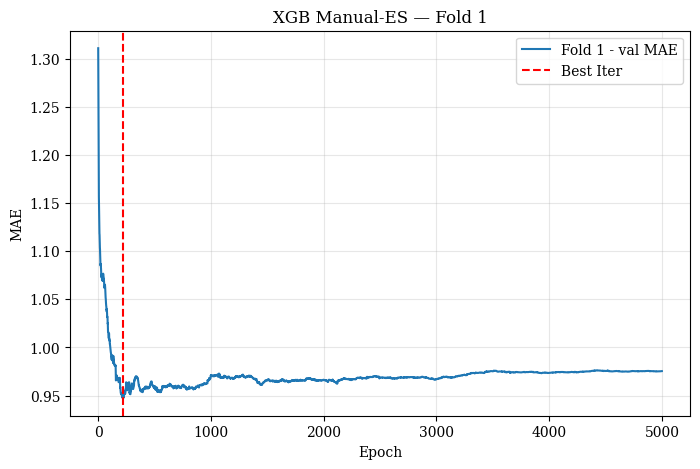

[XGB][Manual-ES][Rolling] best_n≈150 | MAE=0.8701 | RMSE=1.1112 | R2=0.3418
Validation: MAE=0.9312 | RMSE=1.1783 | R2=0.7104
[XGB FE+DT (CV+Val)] time=659.29s | Py-peak=43.0 MB | RSS(before/after/delta)=1017.0/940.5/-76.6 MB

Hiệu năng trên Test:
- MAE : 0.9869
- RMSE: 1.2784
- R2  : 0.6099
[XGB FE+DT (Test)] time=0.01s | Py-peak=0.2 MB | RSS(before/after/delta)=940.5/941.8/1.3 MB


,run,MAE,RMSE,R2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,XGB Original (CV+Val),0.988517,1.220784,0.686197,805.864168,57.666485,788.656250,1048.140625,259.484375
1,XGB Original (Test),0.987520,1.284453,0.606439,0.006589,0.270172,1048.406250,1050.500000,2.093750
2,XGB FE (CV+Val),0.931171,1.175022,0.711973,652.836094,42.125877,1050.500000,786.734375,-263.765625
3,XGB FE (Test),0.991007,1.289620,0.603038,0.005784,0.236439,910.171875,911.484375,1.312500
4,XGB DT (CV+Val),0.974363,1.213622,0.689868,628.443604,37.786814,911.484375,1015.953125,104.468750
5,XGB DT (Test),0.998739,1.304645,0.593967,0.005077,0.228331,1015.968750,1017.046875,1.078125
6,XGB FE+DT (CV+Val),0.931248,1.178311,0.710359,659.292734,42.990638,1017.046875,940.453125,-76.593750
7,XGB FE+DT (Test),0.986902,1.278357,0.609941,0.005766,0.237398,940.484375,941.828125,1.343750


In [53]:
from src.utils.rolling_origin_cv import RollingOriginTimeSeriesSplit
runs_xgb = []

# XGB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_train, y_train, g_train,     
    X_val,   y_val,
    label="XGB Original (CV+Val)"
)
xgb_model, xgb_val_metrics, xgb_info = res1
runs_xgb.append({"run": "XGB Original (CV+Val)", **xgb_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_model, X_test, y_test,
    label="XGB Original (Test)"
)
xgb_test_metrics = res1t
runs_xgb.append({"run": "XGB Original (Test)", **xgb_test_metrics, **stats1t})


# XGB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_fe_train, y_fe_train, g_fe_train,   
    X_fe_val,   y_fe_val,
    label="XGB FE (CV+Val)"
)
xgb_fe_model, xgb_val_fe_metrics, xgb_fe_info = res2
runs_xgb.append({"run": "XGB FE (CV+Val)", **xgb_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_fe_model, X_fe_test, y_fe_test,
    label="XGB FE (Test)"
)
xgb_test_fe_metrics = res2t
runs_xgb.append({"run": "XGB FE (Test)", **xgb_test_fe_metrics, **stats2t})


# XGB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_dt_train, y_dt_train, g_dt_train,   
    X_dt_val,   y_dt_val,
    label="XGB DT (CV+Val)"
)
xgb_dt_model, xgb_val_dt_metrics, xgb_dt_info = res3
runs_xgb.append({"run": "XGB DT (CV+Val)", **xgb_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_dt_model, X_dt_test, y_dt_test,
    label="XGB DT (Test)"
)
xgb_test_dt_metrics = res3t
runs_xgb.append({"run": "XGB DT (Test)", **xgb_test_dt_metrics, **stats3t})


# XGB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_fe_dt_train, y_fe_dt_train, g_fe_dt_train,   
    X_fe_dt_val,   y_fe_dt_val,
    label="XGB FE+DT (CV+Val)"
)
xgb_fe_dt_model, xgb_val_fe_dt_metrics, xgb_fe_dt_info = res4
runs_xgb.append({"run": "XGB FE+DT (CV+Val)", **xgb_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="XGB FE+DT (Test)"
)
xgb_test_fe_dt_metrics = res4t
runs_xgb.append({"run": "XGB FE+DT (Test)", **xgb_test_fe_dt_metrics, **stats4t})

# DataFrame kết quả cho XGB
df_runs_xgb = pd.DataFrame(runs_xgb)
display(df_runs_xgb)

## 4.4. 📈 XGBoost Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R2

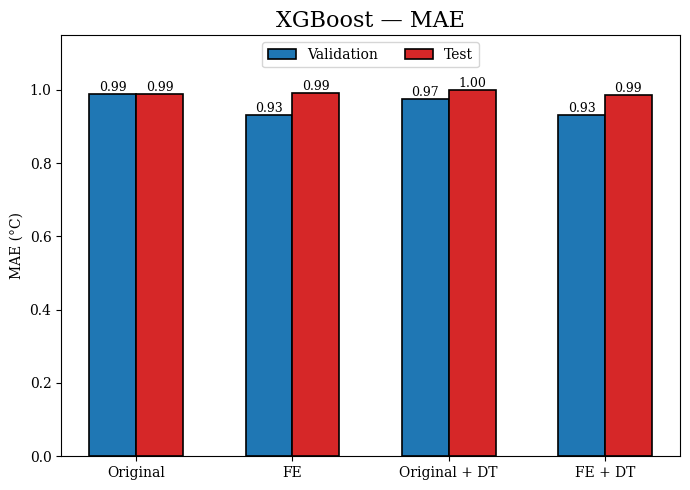

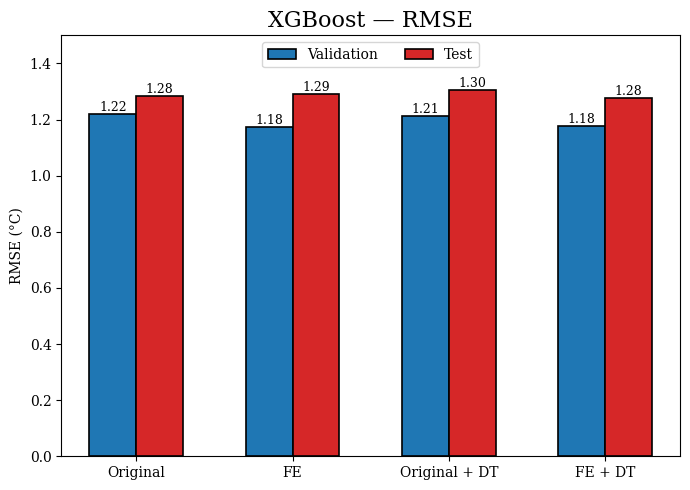

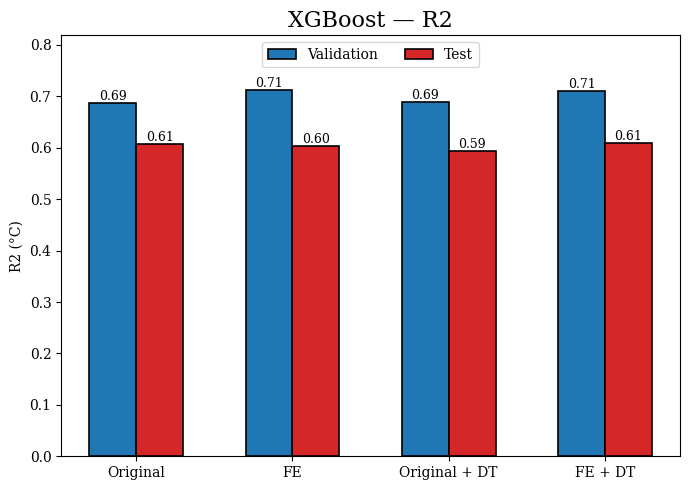

In [54]:
# MAE
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='MAE'
)

# RMSE
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='RMSE'
)

# R2
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='R2'
)

# 5. Linear Regression (Baseline)

In [71]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

print("LINEAR REGRESSION BASELINE")

def evaluate_linear_baseline(X_train, y_train, X_val, y_val, X_test, y_test, model_name="Linear"):
    # Scale features for linear models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    val_pred = model.predict(X_val_scaled)
    test_pred = model.predict(X_test_scaled)
    
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)
    
    print("\nHiệu năng trên Validation:")
    print(f"- MAE : {val_mae:.4f}")
    print(f"- RMSE: {val_rmse:.4f}")
    print(f"- R2  : {val_r2:.4f}")

    print("\nHiệu năng trên Test:")
    print(f"- MAE : {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R2  : {test_r2:.4f}")
    
    return {
        'val_mae': val_mae, 'val_r2': val_r2,
        'val_rmse': val_rmse, 'test_rmse': test_rmse,
        'test_mae': test_mae, 'test_r2': test_r2
    }

# Test on best dataset (FE + DT)
print("Testing Linear Regression on FE + DT dataset:")
linear_results = evaluate_linear_baseline(
    X_fe_dt_train, y_fe_dt_train, 
    X_fe_dt_val, y_fe_dt_val, 
    X_fe_dt_test, y_fe_dt_test, 
    "Linear Regression (FE+DT)"
)


LINEAR REGRESSION BASELINE
Testing Linear Regression on FE + DT dataset:

Hiệu năng trên Validation:
- MAE : 0.9019
- RMSE: 1.1563
- R2  : 0.7211

Hiệu năng trên Test:
- MAE : 1.0082
- RMSE: 1.3356
- R2  : 0.5742


# 5. Comprehensive Model Comparison & Analysis


In [74]:
# 5.1. Create Comprehensive Results Summary
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")

def metric_lookup(metrics_dict, metric, prefix=None):
    metric_variants = {
        metric,
        metric.lower(),
        metric.upper(),
        metric.capitalize()
    }
    candidates = []
    if prefix:
        prefix_variants = {
            prefix,
            prefix.lower(),
            prefix.upper(),
            prefix.capitalize()
        }
        for pref in prefix_variants:
            for met in list(metric_variants):
                candidates.append(f"{pref}_{met}")
                candidates.append(f"{pref}_{met.lower()}")
    candidates.extend(metric_variants)
    for key in candidates:
        if key in metrics_dict:
            return metrics_dict[key]
    raise KeyError(f"Metric '{metric}' not found in keys: {list(metrics_dict.keys())}")

datasets = ['Original', 'FE', 'Original + DT', 'FE + DT']

xgb_results = {
    'Dataset': datasets,
    'Model': ['XGBoost'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]]
}

gb_results = {
    'Dataset': datasets,
    'Model': ['Gradient Boosting'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]]
}

ab_results = {
    'Dataset': datasets,
    'Model': ['AdaBoost'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]]
}

rf_results = {
    'Dataset': datasets,
    'Model': ['Random Forest'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]]
}

ln_results = {
    'Dataset': ['FE + DT'],  # Chỉ 1 dataset
    'Model': ['Linear Regression'],  # Chỉ 1 model
    'Val_MAE': [linear_results['val_mae']],
    'Test_MAE': [linear_results['test_mae']],
    'Val_RMSE': [linear_results['val_rmse']],
    'Test_RMSE': [linear_results['test_rmse']],
    'Val_R2': [linear_results['val_r2']],
    'Test_R2': [linear_results['test_r2']]
}

xgb_results_df = pd.DataFrame(xgb_results)
print("XGBoost Results:")
display(xgb_results_df)
gb_results_df = pd.DataFrame(gb_results)
print("Gradient Boosting Results:")
display(gb_results_df)
ab_results_df = pd.DataFrame(ab_results)
print("AdaBoost Results:")
display(ab_results_df)
rf_results_df = pd.DataFrame(rf_results)
print("Random Forest Results:")
display(rf_results_df)
ln_results_df = pd.DataFrame(ln_results)
print("Linear Regression (Baseline) Results:")
display(ln_results_df)


COMPREHENSIVE MODEL PERFORMANCE SUMMARY
XGBoost Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,XGBoost,0.988517,0.987520,1.220784,1.284453,0.686197,0.606439
1,FE,XGBoost,0.931171,0.991007,1.175022,1.289620,0.711973,0.603038
2,Original + DT,XGBoost,0.974363,0.998739,1.213622,1.304645,0.689868,0.593967
3,FE + DT,XGBoost,0.931248,0.986902,1.178311,1.278357,0.710359,0.609941


Gradient Boosting Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,Gradient Boosting,1.054037,1.021513,1.292894,1.323843,0.648030,0.581930
1,FE,Gradient Boosting,0.973399,1.003344,1.220699,1.300812,0.689145,0.596118
2,Original + DT,Gradient Boosting,1.053279,1.028539,1.293567,1.330310,0.647663,0.577835
3,FE + DT,Gradient Boosting,0.941358,0.989594,1.190194,1.280318,0.704487,0.608743


AdaBoost Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,AdaBoost,1.298713,1.124838,1.567223,1.437553,0.482821,0.507027
1,FE,AdaBoost,1.117519,1.088584,1.383617,1.381022,0.600633,0.544774
2,Original + DT,AdaBoost,1.297038,1.122961,1.566223,1.436092,0.483480,0.508028
3,FE + DT,AdaBoost,1.126500,1.083776,1.390753,1.377583,0.596502,0.547038


Random Forest Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,Random Forest,0.997141,1.011927,1.237717,1.318428,0.677431,0.585343
1,FE,Random Forest,0.946103,1.000177,1.193392,1.298245,0.702897,0.597710
2,Original + DT,Random Forest,0.992439,1.013617,1.235329,1.319523,0.678675,0.584654
3,FE + DT,Random Forest,0.949420,0.993588,1.196973,1.287057,0.701111,0.604614


Linear Regression (Baseline) Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,FE + DT,Linear Regression,0.901922,1.008178,1.156308,1.335595,0.721075,0.574229


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
            feature  importance
tempmax_C_rollmean3    0.242773
             temp_C    0.185638
tempmax_C_rollmean7    0.095538
     tempmax_C_lag1    0.051780
        feelslike_C    0.036661
     solarradiation    0.031946
     feelslikemax_C    0.030654
            winddir    0.025294
            doy_sin    0.024511
   sealevelpressure    0.023750


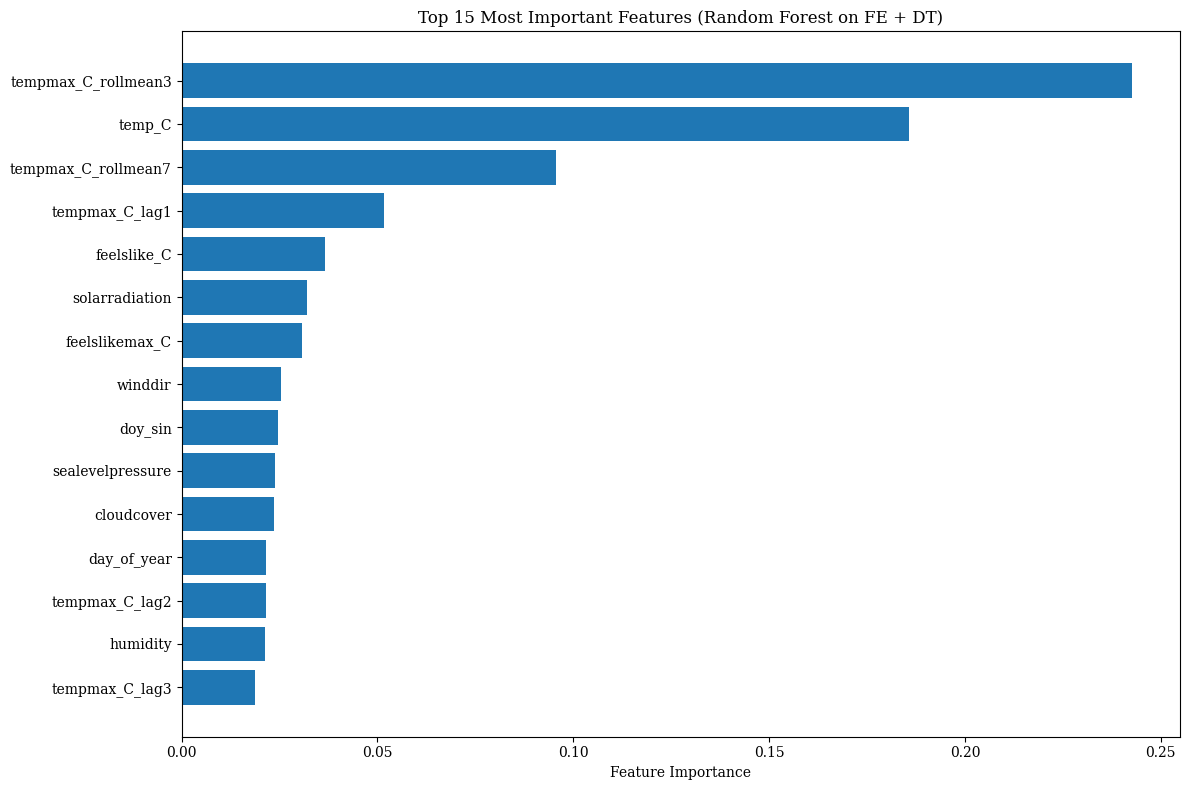

In [58]:
print("FEATURE IMPORTANCE ANALYSIS")
# Get feature importance from best RandomForest model
feature_importance = rf_fe_dt_model.feature_importances_
feature_names = X_fe_dt_train.columns

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest on FE + DT)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# **6. Error Analysis & Residual Plots**

## Mục tiêu
- Phân tích residual plots để hiểu cách models dự đoán sai
- Phân tích phân phối lỗi (histogram, Q-Q plots)
- Phân tích lỗi theo thời gian (time series errors)
- Xác định patterns trong prediction errors


In [87]:
# Helper Functions for Error Analysis

def plot_residual_analysis(model_name, y_true, y_pred, datetime_col=None, figsize=(15, 10)):
    """
    Tạo comprehensive residual analysis plots:
    1. Actual vs Predicted (scatter)
    2. Residuals vs Predicted
    3. Residual distribution (histogram + KDE)
    4. Q-Q plot của residuals
    5. Residuals over time (nếu có datetime)
    """
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'{model_name} - Residual Analysis', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted
    ax1 = axes[0, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=10)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Actual vs Predicted')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuals vs Predicted
    ax2 = axes[0, 1]
    ax2.scatter(y_pred, residuals, alpha=0.5, s=10)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals (Actual - Predicted)')
    ax2.set_title('Residuals vs Predicted')
    ax2.grid(True, alpha=0.3)
    
    # 3. Residual Histogram + KDE
    ax3 = axes[0, 2]
    ax3.hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
    # Overlay normal distribution
    from scipy import stats
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax3.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Density')
    ax3.set_title('Residual Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Q-Q Plot
    ax4 = axes[1, 0]
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Test)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Residuals over Time (nếu có datetime)
    if datetime_col is not None:
        ax5 = axes[1, 1]
        ax5.plot(datetime_col, residuals, alpha=0.6, linewidth=0.5)
        ax5.axhline(y=0, color='r', linestyle='--', lw=2)
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Residuals')
        ax5.set_title('Residuals Over Time')
        ax5.grid(True, alpha=0.3)
        plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax5 = axes[1, 1]
        ax5.text(0.5, 0.5, 'No datetime column provided', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Residuals Over Time (Not Available)')
    
    # 6. Error Statistics Summary
    ax6 = axes[1, 2]
    ax6.axis('off')
    stats_text = f"""
    Residual Statistics:
    --------------------
    Mean:        {residuals.mean():.4f}
    Std Dev:     {residuals.std():.4f}
    Min:         {residuals.min():.4f}
    25th %ile:   {residuals.quantile(0.25):.4f}
    Median:      {residuals.median():.4f}
    75th %ile:   {residuals.quantile(0.75):.4f}
    Max:         {residuals.max():.4f}
    
    MAE:         {np.mean(np.abs(residuals)):.4f}
    RMSE:        {np.sqrt(np.mean(residuals**2)):.4f}
    
    Normality Test (Shapiro-Wilk):
    p-value:     {stats.shapiro(residuals)[1]:.4f}
    """
    ax6.text(0.1, 0.5, stats_text, transform=ax6.transAxes, 
            fontsize=10, family='monospace', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    return residuals

def plot_error_distribution_comparison(models_dict, figsize=(15, 10)):
    """
    So sánh phân phối lỗi của nhiều models
    models_dict: {'Model Name': (y_true, y_pred)}
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Error Distribution Comparison Across Models', fontsize=16, fontweight='bold')
    
    all_residuals = []
    model_names = []
    
    # Tính residuals cho tất cả models
    for name, (y_true, y_pred) in models_dict.items():
        residuals = y_true - y_pred
        all_residuals.append(residuals)
        model_names.append(name)
    
    # 1. Box plots
    ax1 = axes[0, 0]
    bp = ax1.boxplot(all_residuals, labels=model_names, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax1.axhline(y=0, color='r', linestyle='--', lw=2)
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residual Distribution (Box Plot)')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Violin plots
    ax2 = axes[0, 1]
    parts = ax2.violinplot(all_residuals, positions=range(len(model_names)), showmeans=True)
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Distribution (Violin Plot)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Histogram overlay
    ax3 = axes[1, 0]
    for i, (name, residuals) in enumerate(zip(model_names, all_residuals)):
        ax3.hist(residuals, bins=50, alpha=0.5, label=name, density=True)
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Density')
    ax3.set_title('Residual Distribution (Histogram Overlay)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Summary statistics table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    stats_data = []
    for name, residuals in zip(model_names, all_residuals):
        stats_data.append({
            'Model': name,
            'Mean': f"{residuals.mean():.4f}",
            'Std': f"{residuals.std():.4f}",
            'MAE': f"{np.mean(np.abs(residuals)):.4f}",
            'RMSE': f"{np.sqrt(np.mean(residuals**2)):.4f}",
            'Min': f"{residuals.min():.4f}",
            'Max': f"{residuals.max():.4f}"
        })
    
    stats_df = pd.DataFrame(stats_data)
    table = ax4.table(cellText=stats_df.values, colLabels=stats_df.columns,
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax4.set_title('Residual Statistics Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()


In [92]:
# Residual Analysis for Best Models (Test Set)

# Lấy predictions từ các best models trên test set
from scipy import stats

# Best XGBoost model (FE+DT)
xgb_fe_dt_test_pred = xgb_fe_dt_model.predict(X_fe_dt_test)

# Best RF model (FE+DT)
rf_fe_dt_test_pred = rf_fe_dt_model.predict(X_fe_dt_test)

# Best GB model (FE+DT)
gb_fe_dt_test_pred = gb_fe_dt_model.predict(X_fe_dt_test)

# Linear Regression Baseline (FE+DT) - cần train lại để có predictions
scaler_ln = StandardScaler()
X_fe_dt_test_scaled = scaler_ln.fit_transform(X_fe_dt_train)
X_fe_dt_test_scaled_test = scaler_ln.transform(X_fe_dt_test)
ln_fe_dt_model = LinearRegression()
ln_fe_dt_model.fit(scaler_ln.fit_transform(X_fe_dt_train), y_fe_dt_train)
ln_fe_dt_test_pred = ln_fe_dt_model.predict(X_fe_dt_test_scaled_test)


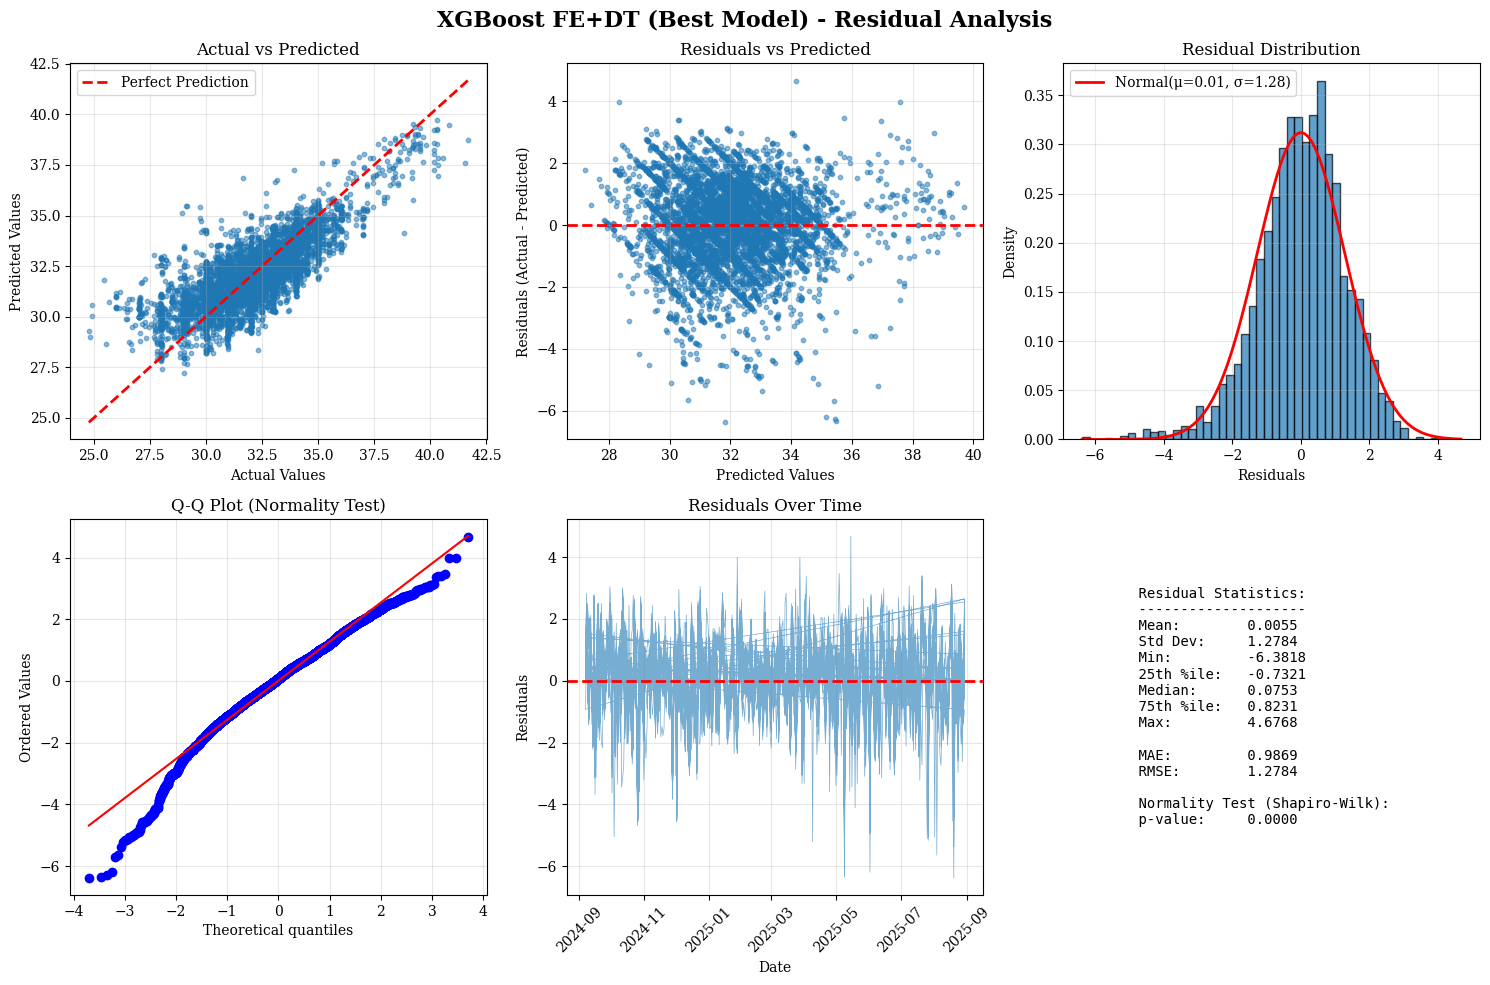

In [93]:
# Residual Analysis for XGBoost FE+DT (Best Model)

# Sử dụng datetime từ test dataframe nếu có
xgb_residuals = plot_residual_analysis(
    'XGBoost FE+DT (Best Model)',
    y_fe_dt_test,
    xgb_fe_dt_test_pred,
    datetime_col=df_fe_dt_test['datetime'] if 'datetime' in df_fe_dt_test.columns else None
)


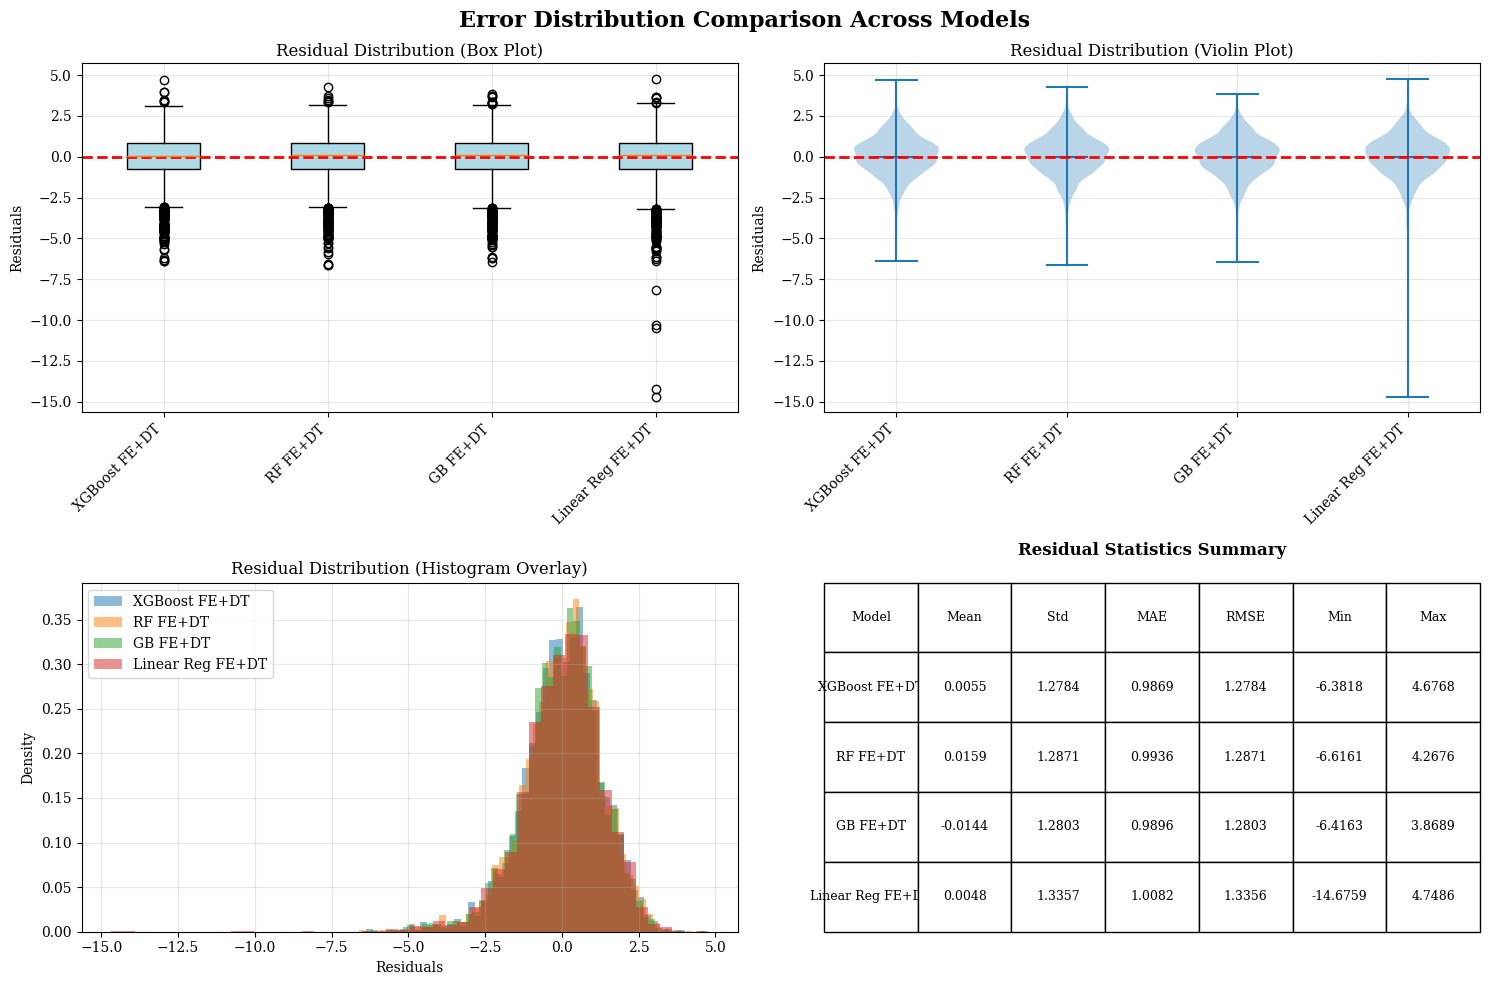

In [94]:
# Error Distribution Comparison Across Models

models_for_comparison = {
    'XGBoost FE+DT': (y_fe_dt_test, xgb_fe_dt_test_pred),
    'RF FE+DT': (y_fe_dt_test, rf_fe_dt_test_pred),
    'GB FE+DT': (y_fe_dt_test, gb_fe_dt_test_pred),
    'Linear Reg FE+DT': (y_fe_dt_test, ln_fe_dt_test_pred)
}

plot_error_distribution_comparison(models_for_comparison)


# **7. Comprehensive Model Comparison Visualization**

## Mục tiêu
- Heatmap so sánh models (MAE, RMSE, R²)
- Bar charts tổng hợp performance
- Box plots phân phối scores


In [119]:
# Create Comprehensive Comparison DataFrame

# Sử dụng hàm metric_lookup để xử lý các format metrics khác nhau
def safe_get_metric(metrics_dict, metric, prefix=None):
    """Safely get metric value - handles various key formats"""
    metric_variants = {
        metric,
        metric.lower(),
        metric.upper(),
        metric.capitalize()
    }
    candidates = []
    
    # Nếu prefix được chỉ định, thêm các variants với prefix
    if prefix:
        prefix_variants = {
            prefix,
            prefix.lower(),
            prefix.upper(),
            prefix.capitalize()
        }
        for pref in prefix_variants:
            for met in list(metric_variants):
                candidates.append(f"{pref}_{met}")
                candidates.append(f"{pref}_{met.lower()}")
                candidates.append(f"{pref}_{met.upper()}")
    else:
        # Nếu không có prefix, thử cả "test_" prefix (một số models dùng format này)
        for pref in ['test', 'Test', 'TEST']:
            for met in list(metric_variants):
                candidates.append(f"{pref}_{met}")
                candidates.append(f"{pref}_{met.lower()}")
                candidates.append(f"{pref}_{met.upper()}")
    
    # Thêm các variants không có prefix (cho test metrics như "MAE", "RMSE", "R2")
    candidates.extend(metric_variants)
    
    # Thử tìm key
    for key in candidates:
        if key in metrics_dict:
            return metrics_dict[key]
    
    raise KeyError(f"Metric '{metric}' (prefix='{prefix}') not found in keys: {list(metrics_dict.keys())}")

# Gộp tất cả kết quả vào một DataFrame để so sánh
all_models_results = []

# XGBoost results
for i, dataset in enumerate(['Original', 'FE', 'Original + DT', 'FE + DT']):
    val_mets = [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics][i]
    test_mets = [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics][i]
    all_models_results.append({
        'Model': 'XGBoost',
        'Dataset': dataset,
        'Val_MAE': safe_get_metric(val_mets, 'mae', prefix='val'),
        'Val_RMSE': safe_get_metric(val_mets, 'rmse', prefix='val'),
        'Val_R2': safe_get_metric(val_mets, 'r2', prefix='val'),
        'Test_MAE': safe_get_metric(test_mets, 'mae', prefix=None),  # Test metrics không có prefix
        'Test_RMSE': safe_get_metric(test_mets, 'rmse', prefix=None),
        'Test_R2': safe_get_metric(test_mets, 'r2', prefix=None)
    })

# Gradient Boosting results
for i, dataset in enumerate(['Original', 'FE', 'Original + DT', 'FE + DT']):
    val_mets = [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics][i]
    test_mets = [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics][i]
    all_models_results.append({
        'Model': 'Gradient Boosting',
        'Dataset': dataset,
        'Val_MAE': safe_get_metric(val_mets, 'mae', prefix='val'),
        'Val_RMSE': safe_get_metric(val_mets, 'rmse', prefix='val'),
        'Val_R2': safe_get_metric(val_mets, 'r2', prefix='val'),
        'Test_MAE': safe_get_metric(test_mets, 'mae', prefix=None),
        'Test_RMSE': safe_get_metric(test_mets, 'rmse', prefix=None),
        'Test_R2': safe_get_metric(test_mets, 'r2', prefix=None)
    })

# Random Forest results
for i, dataset in enumerate(['Original', 'FE', 'Original + DT', 'FE + DT']):
    val_mets = [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics][i]
    test_mets = [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics][i]
    all_models_results.append({
        'Model': 'Random Forest',
        'Dataset': dataset,
        'Val_MAE': safe_get_metric(val_mets, 'mae', prefix='val'),
        'Val_RMSE': safe_get_metric(val_mets, 'rmse', prefix='val'),
        'Val_R2': safe_get_metric(val_mets, 'r2', prefix='val'),
        'Test_MAE': safe_get_metric(test_mets, 'mae', prefix=None),
        'Test_RMSE': safe_get_metric(test_mets, 'rmse', prefix=None),
        'Test_R2': safe_get_metric(test_mets, 'r2', prefix=None)
    })

# AdaBoost results
for i, dataset in enumerate(['Original', 'FE', 'Original + DT', 'FE + DT']):
    val_mets = [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics][i]
    test_mets = [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics][i]
    all_models_results.append({
        'Model': 'AdaBoost',
        'Dataset': dataset,
        'Val_MAE': safe_get_metric(val_mets, 'mae', prefix='val'),
        'Val_RMSE': safe_get_metric(val_mets, 'rmse', prefix='val'),
        'Val_R2': safe_get_metric(val_mets, 'r2', prefix='val'),
        'Test_MAE': safe_get_metric(test_mets, 'mae', prefix=None),
        'Test_RMSE': safe_get_metric(test_mets, 'rmse', prefix=None),
        'Test_R2': safe_get_metric(test_mets, 'r2', prefix=None)
    })

# Linear Regression (chỉ có FE+DT)
all_models_results.append({
    'Model': 'Linear Regression',
    'Dataset': 'FE + DT',
    'Val_MAE': linear_results['val_mae'],
    'Val_RMSE': linear_results['val_rmse'],
    'Val_R2': linear_results['val_r2'],
    'Test_MAE': linear_results['test_mae'],
    'Test_RMSE': linear_results['test_rmse'],
    'Test_R2': linear_results['test_r2']
})

comparison_df = pd.DataFrame(all_models_results)
display(comparison_df.head(20))


,Model,Dataset,Val_MAE,Val_RMSE,Val_R2,Test_MAE,Test_RMSE,Test_R2
0,XGBoost,Original,0.988517,1.220784,0.686197,0.987520,1.284453,0.606439
1,XGBoost,FE,0.931171,1.175022,0.711973,0.991007,1.289620,0.603038
2,XGBoost,Original + DT,0.974363,1.213622,0.689868,0.998739,1.304645,0.593967
3,XGBoost,FE + DT,0.931248,1.178311,0.710359,0.986902,1.278357,0.609941
4,Gradient Boosting,Original,1.054037,1.292894,0.648030,1.021513,1.323843,0.581930
5,Gradient Boosting,FE,0.973399,1.220699,0.689145,1.003344,1.300812,0.596118
6,Gradient Boosting,Original + DT,1.053279,1.293567,0.647663,1.028539,1.330310,0.577835
7,Gradient Boosting,FE + DT,0.941358,1.190194,0.704487,0.989594,1.280318,0.608743
8,Random Forest,Original,0.997141,1.237717,0.677431,1.011927,1.318428,0.585343
9,Random Forest,FE,0.946103,1.193392,0.702897,1.000177,1.298245,0.597710


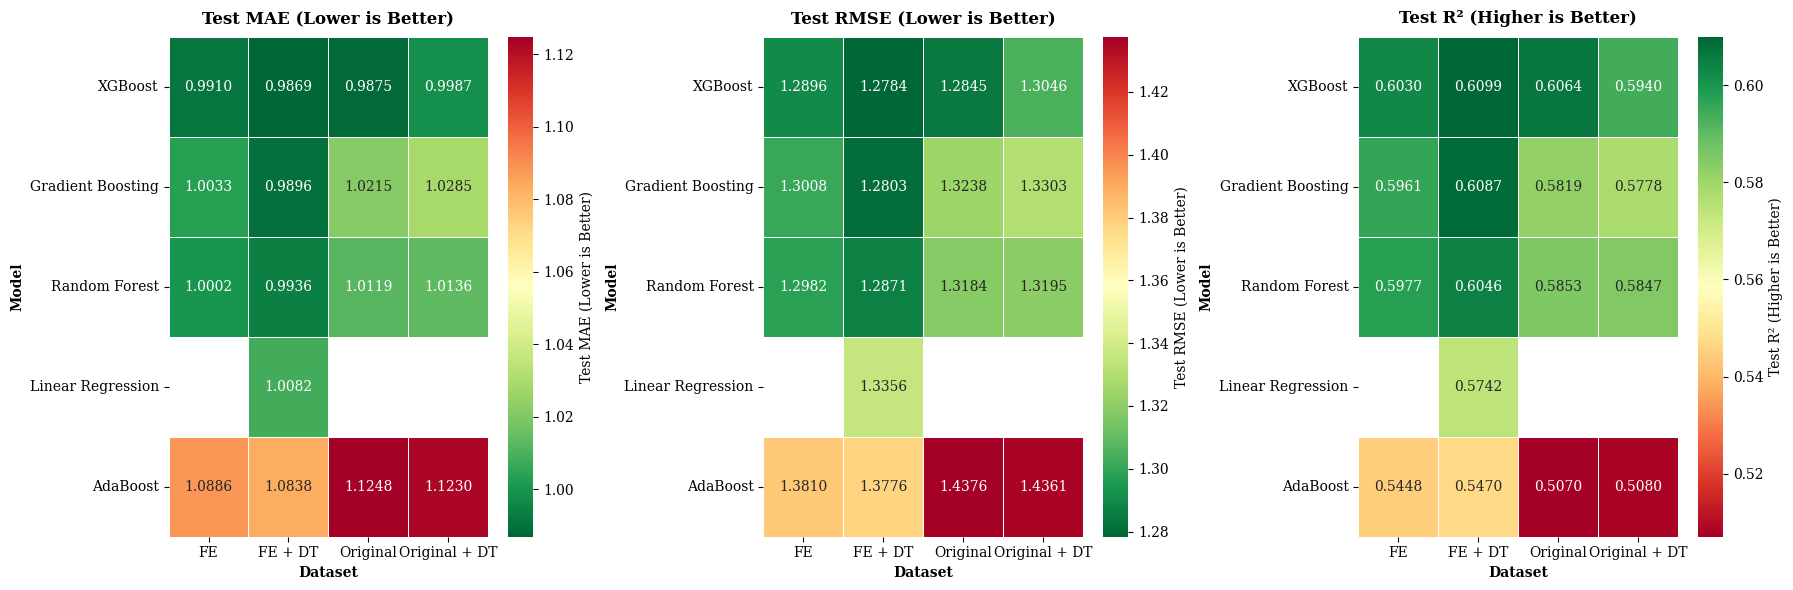

In [121]:
# Heatmap Comparison - Test Set Performance

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Test_MAE', 'Test_RMSE', 'Test_R2']
metric_names = ['Test MAE (Lower is Better)', 'Test RMSE (Lower is Better)', 'Test R² (Higher is Better)']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    # Pivot table để tạo heatmap
    pivot_data = comparison_df.pivot(index='Model', columns='Dataset', values=metric)
    
    # Sắp xếp models theo performance (best to worst)
    if 'R2' in metric:
        # R2: higher is better
        pivot_data = pivot_data.sort_values(by='FE + DT', ascending=False)
        cmap = 'RdYlGn'
        fmt = '.4f'
    else:
        # MAE/RMSE: lower is better
        pivot_data = pivot_data.sort_values(by='FE + DT', ascending=True)
        cmap = 'RdYlGn_r'
        fmt = '.4f'
    
    sns.heatmap(pivot_data, annot=True, fmt=fmt, cmap=cmap, 
                ax=axes[idx], cbar_kws={'label': name}, linewidths=0.5)
    axes[idx].set_title(name, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Dataset', fontweight='bold')
    axes[idx].set_ylabel('Model', fontweight='bold')

plt.tight_layout()
plt.show()


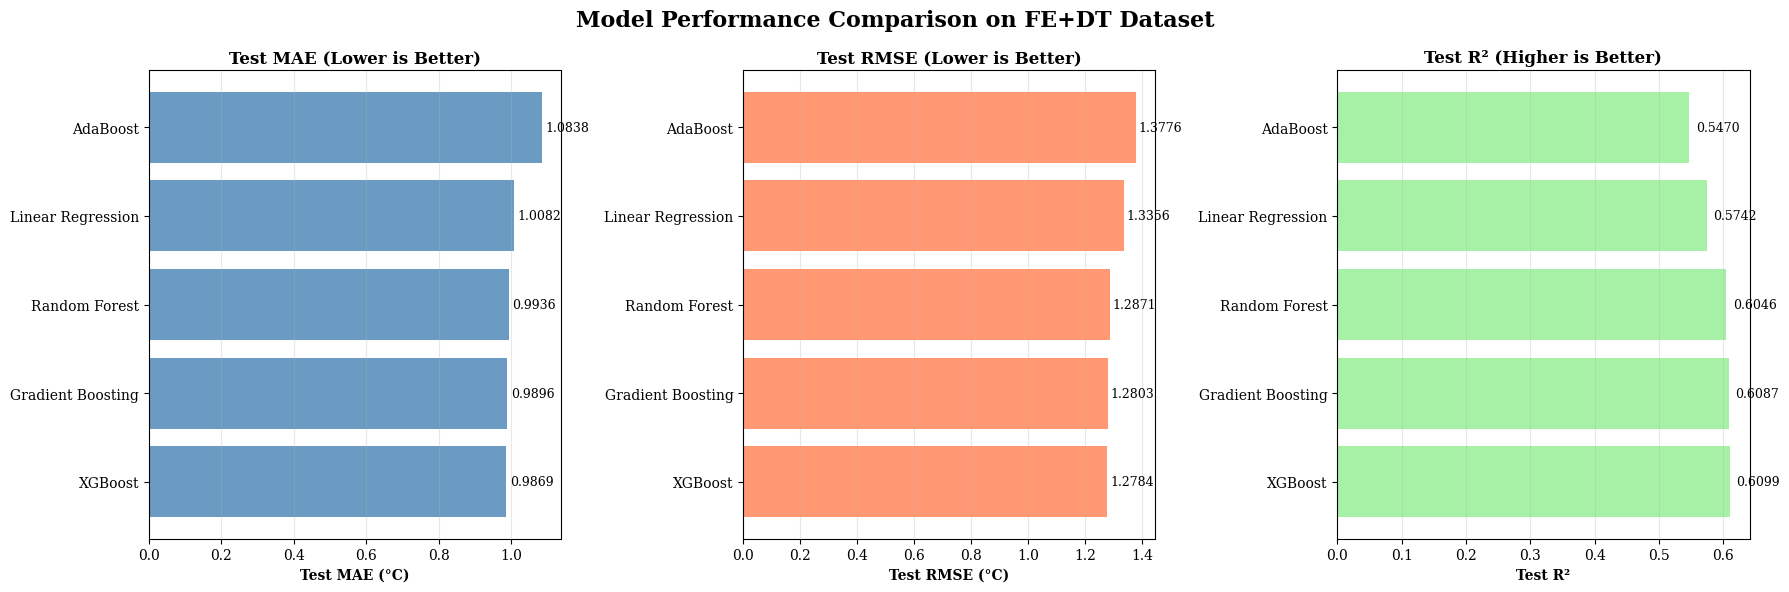


Best Model (Lowest Test MAE): XGBoost - 0.9869°C
Best Model (Highest Test R²): XGBoost - 0.6099


In [122]:
# Bar Charts - Performance Comparison (Best Dataset: FE+DT)

# Filter chỉ FE+DT dataset
fe_dt_results = comparison_df[comparison_df['Dataset'] == 'FE + DT'].copy()
fe_dt_results = fe_dt_results.sort_values('Test_MAE', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Model Performance Comparison on FE+DT Dataset', fontsize=16, fontweight='bold')

# Test MAE
axes[0].barh(fe_dt_results['Model'], fe_dt_results['Test_MAE'], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Test MAE (°C)', fontweight='bold')
axes[0].set_title('Test MAE (Lower is Better)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(fe_dt_results['Test_MAE']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

# Test RMSE
axes[1].barh(fe_dt_results['Model'], fe_dt_results['Test_RMSE'], color='coral', alpha=0.8)
axes[1].set_xlabel('Test RMSE (°C)', fontweight='bold')
axes[1].set_title('Test RMSE (Lower is Better)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(fe_dt_results['Test_RMSE']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

# Test R²
axes[2].barh(fe_dt_results['Model'], fe_dt_results['Test_R2'], color='lightgreen', alpha=0.8)
axes[2].set_xlabel('Test R²', fontweight='bold')
axes[2].set_title('Test R² (Higher is Better)', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
for i, v in enumerate(fe_dt_results['Test_R2']):
    axes[2].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nBest Model (Lowest Test MAE): {fe_dt_results.iloc[0]['Model']} - {fe_dt_results.iloc[0]['Test_MAE']:.4f}°C")
print(f"Best Model (Highest Test R²): {fe_dt_results.loc[fe_dt_results['Test_R2'].idxmax(), 'Model']} - {fe_dt_results['Test_R2'].max():.4f}")


# **8. Time Series Prediction Visualization**

## Mục tiêu
- Plot predictions của best models trên test set theo thời gian
- So sánh multiple models trên cùng timeframe
- Hiểu patterns trong predictions


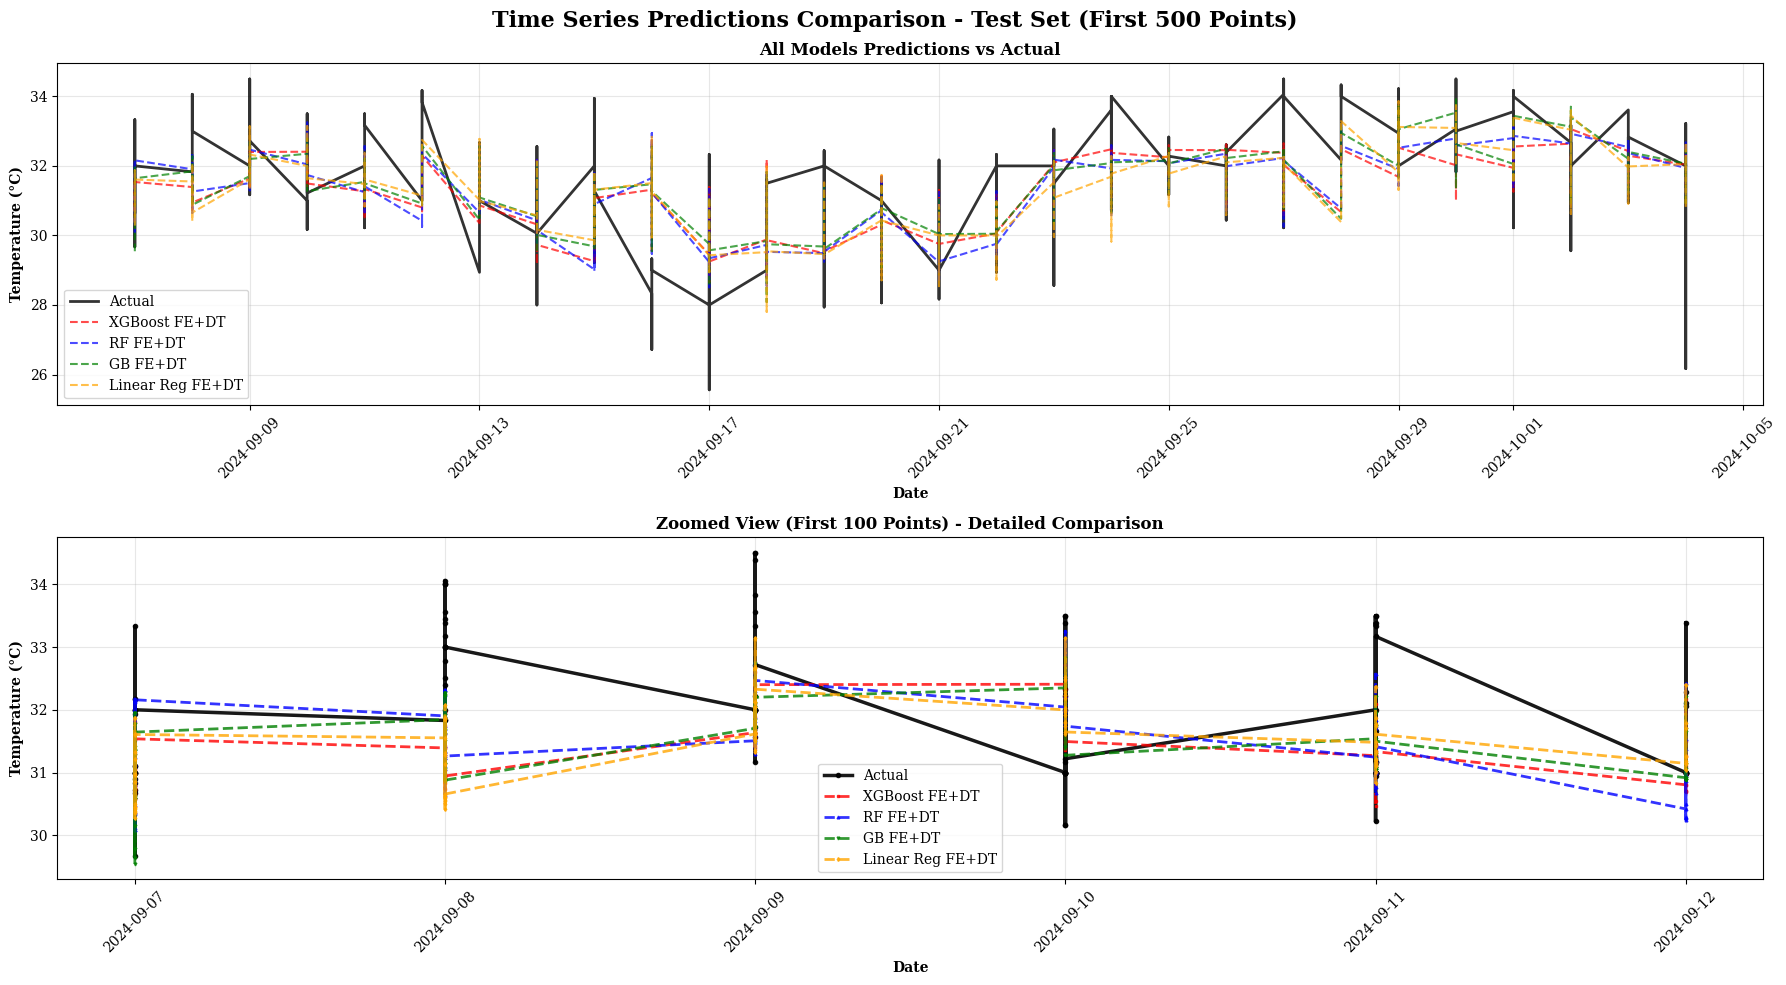

Time series plotted for 500 points (out of 6444 total test points)


In [118]:
# Time Series Predictions - Best Models Comparison

# Tạo DataFrame với datetime và predictions
if 'datetime' in df_fe_dt_test.columns:
    ts_df = pd.DataFrame({
        'datetime': df_fe_dt_test['datetime'].values,
        'Actual': y_fe_dt_test.values,
        'XGBoost FE+DT': xgb_fe_dt_test_pred,
        'RF FE+DT': rf_fe_dt_test_pred,
        'GB FE+DT': gb_fe_dt_test_pred,
        'Linear Reg FE+DT': ln_fe_dt_test_pred
    })
    ts_df = ts_df.sort_values('datetime').reset_index(drop=True)
    
    # Plot first 500 points để dễ nhìn (hoặc có thể plot toàn bộ)
    plot_df = ts_df.head(500) if len(ts_df) > 500 else ts_df
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    fig.suptitle('Time Series Predictions Comparison - Test Set (First 500 Points)', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: All models together
    ax1 = axes[0]
    ax1.plot(plot_df['datetime'], plot_df['Actual'], 'k-', linewidth=2, label='Actual', alpha=0.8)
    ax1.plot(plot_df['datetime'], plot_df['XGBoost FE+DT'], 'r--', linewidth=1.5, label='XGBoost FE+DT', alpha=0.7)
    ax1.plot(plot_df['datetime'], plot_df['RF FE+DT'], 'b--', linewidth=1.5, label='RF FE+DT', alpha=0.7)
    ax1.plot(plot_df['datetime'], plot_df['GB FE+DT'], 'g--', linewidth=1.5, label='GB FE+DT', alpha=0.7)
    ax1.plot(plot_df['datetime'], plot_df['Linear Reg FE+DT'], 'orange', linestyle='--', linewidth=1.5, label='Linear Reg FE+DT', alpha=0.7)
    ax1.set_xlabel('Date', fontweight='bold')
    ax1.set_ylabel('Temperature (°C)', fontweight='bold')
    ax1.set_title('All Models Predictions vs Actual', fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Zoom vào một khoảng nhỏ hơn để thấy chi tiết
    zoom_df = plot_df.head(100) if len(plot_df) >= 100 else plot_df
    ax2 = axes[1]
    ax2.plot(zoom_df['datetime'], zoom_df['Actual'], 'k-', linewidth=2.5, label='Actual', alpha=0.9, marker='o', markersize=3)
    ax2.plot(zoom_df['datetime'], zoom_df['XGBoost FE+DT'], 'r--', linewidth=2, label='XGBoost FE+DT', alpha=0.8, marker='s', markersize=2)
    ax2.plot(zoom_df['datetime'], zoom_df['RF FE+DT'], 'b--', linewidth=2, label='RF FE+DT', alpha=0.8, marker='^', markersize=2)
    ax2.plot(zoom_df['datetime'], zoom_df['GB FE+DT'], 'g--', linewidth=2, label='GB FE+DT', alpha=0.8, marker='v', markersize=2)
    ax2.plot(zoom_df['datetime'], zoom_df['Linear Reg FE+DT'], 'orange', linestyle='--', linewidth=2, label='Linear Reg FE+DT', alpha=0.8, marker='d', markersize=2)
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('Temperature (°C)', fontweight='bold')
    ax2.set_title('Zoomed View (First 100 Points) - Detailed Comparison', fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Time series plotted for {len(plot_df)} points (out of {len(ts_df)} total test points)")
else:
    print("Warning: No datetime column found in test dataframe. Cannot plot time series.")


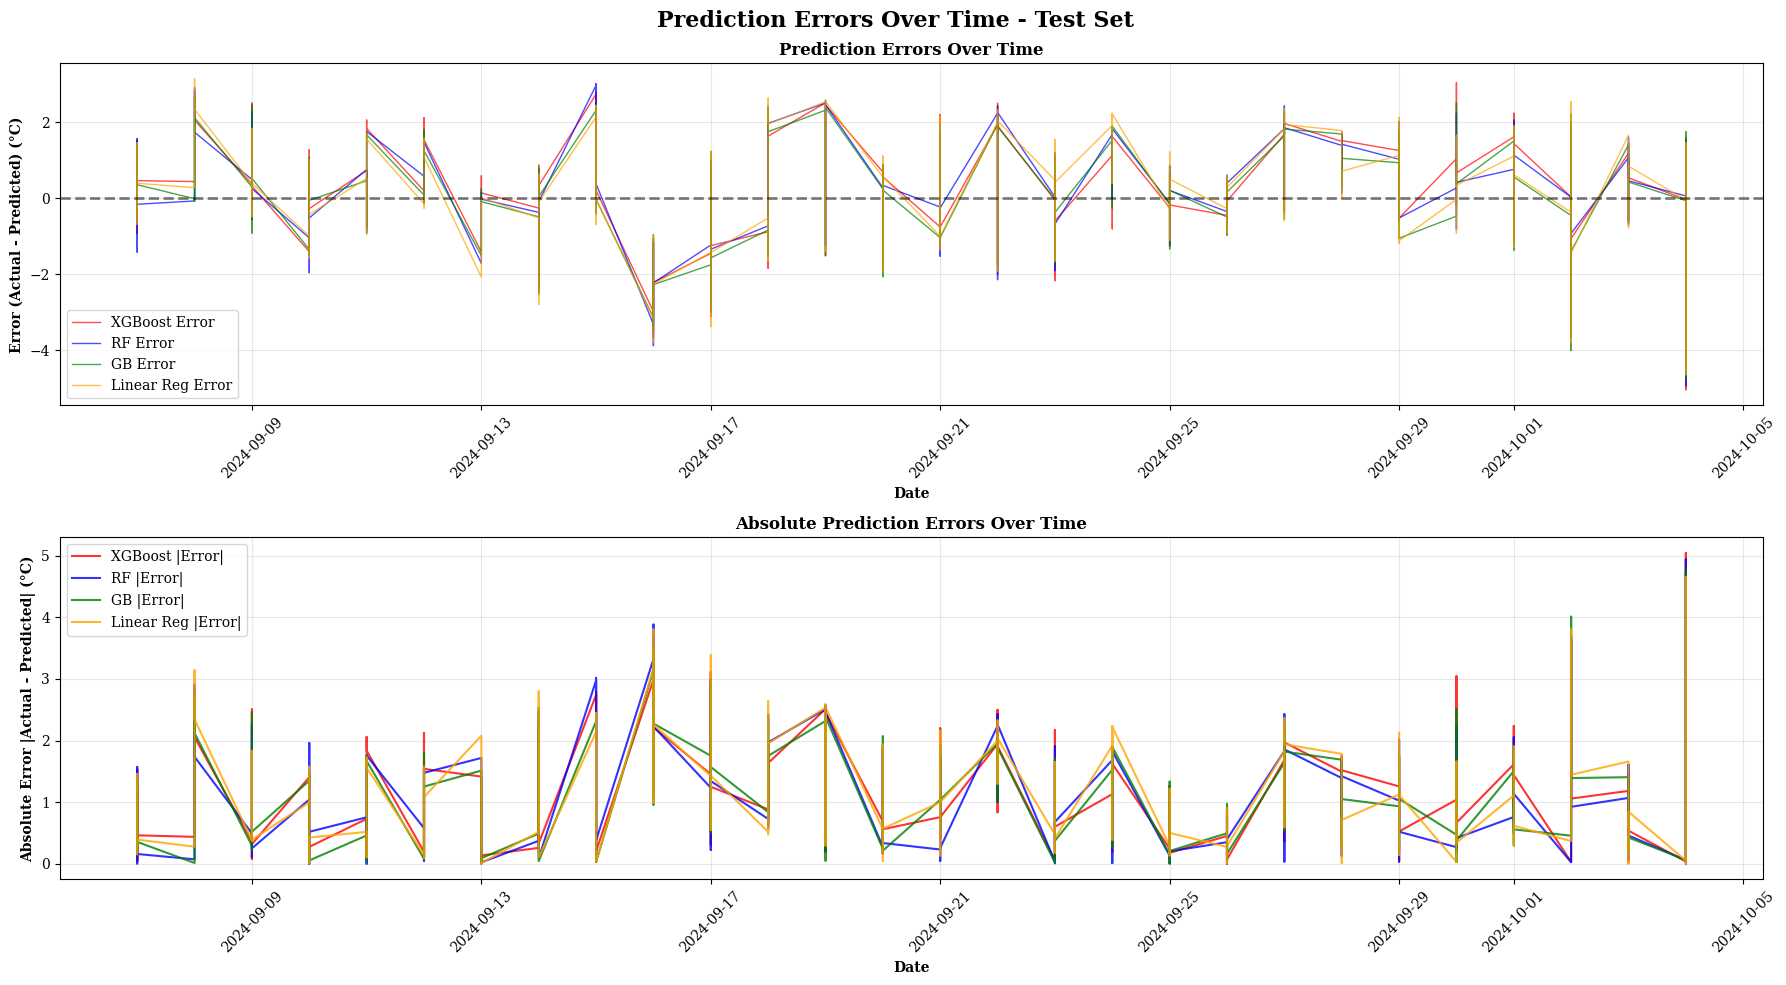

In [117]:
# Prediction Errors Over Time

if 'datetime' in df_fe_dt_test.columns:
    # Tính errors cho từng model
    error_df = pd.DataFrame({
        'datetime': df_fe_dt_test['datetime'].values,
        'XGBoost Error': (y_fe_dt_test.values - xgb_fe_dt_test_pred),
        'RF Error': (y_fe_dt_test.values - rf_fe_dt_test_pred),
        'GB Error': (y_fe_dt_test.values - gb_fe_dt_test_pred),
        'Linear Reg Error': (y_fe_dt_test.values - ln_fe_dt_test_pred)
    })
    error_df = error_df.sort_values('datetime').reset_index(drop=True)
    plot_error_df = error_df.head(500) if len(error_df) > 500 else error_df
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    fig.suptitle('Prediction Errors Over Time - Test Set', fontsize=16, fontweight='bold')
    
    # Plot 1: All errors
    ax1 = axes[0]
    ax1.plot(plot_error_df['datetime'], plot_error_df['XGBoost Error'], 'r-', linewidth=1, label='XGBoost Error', alpha=0.7)
    ax1.plot(plot_error_df['datetime'], plot_error_df['RF Error'], 'b-', linewidth=1, label='RF Error', alpha=0.7)
    ax1.plot(plot_error_df['datetime'], plot_error_df['GB Error'], 'g-', linewidth=1, label='GB Error', alpha=0.7)
    ax1.plot(plot_error_df['datetime'], plot_error_df['Linear Reg Error'], 'orange', linewidth=1, label='Linear Reg Error', alpha=0.7)
    ax1.axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.5)
    ax1.set_xlabel('Date', fontweight='bold')
    ax1.set_ylabel('Error (Actual - Predicted) (°C)', fontweight='bold')
    ax1.set_title('Prediction Errors Over Time', fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Absolute errors
    ax2 = axes[1]
    ax2.plot(plot_error_df['datetime'], np.abs(plot_error_df['XGBoost Error']), 'r-', linewidth=1.5, label='XGBoost |Error|', alpha=0.8)
    ax2.plot(plot_error_df['datetime'], np.abs(plot_error_df['RF Error']), 'b-', linewidth=1.5, label='RF |Error|', alpha=0.8)
    ax2.plot(plot_error_df['datetime'], np.abs(plot_error_df['GB Error']), 'g-', linewidth=1.5, label='GB |Error|', alpha=0.8)
    ax2.plot(plot_error_df['datetime'], np.abs(plot_error_df['Linear Reg Error']), 'orange', linewidth=1.5, label='Linear Reg |Error|', alpha=0.8)
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('Absolute Error |Actual - Predicted| (°C)', fontweight='bold')
    ax2.set_title('Absolute Prediction Errors Over Time', fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()


# **9. Advanced Analysis**

## Mục tiêu
- Performance theo provinces (nếu có)
- Performance theo seasonality (mùa, tháng)
- Identify patterns và insights


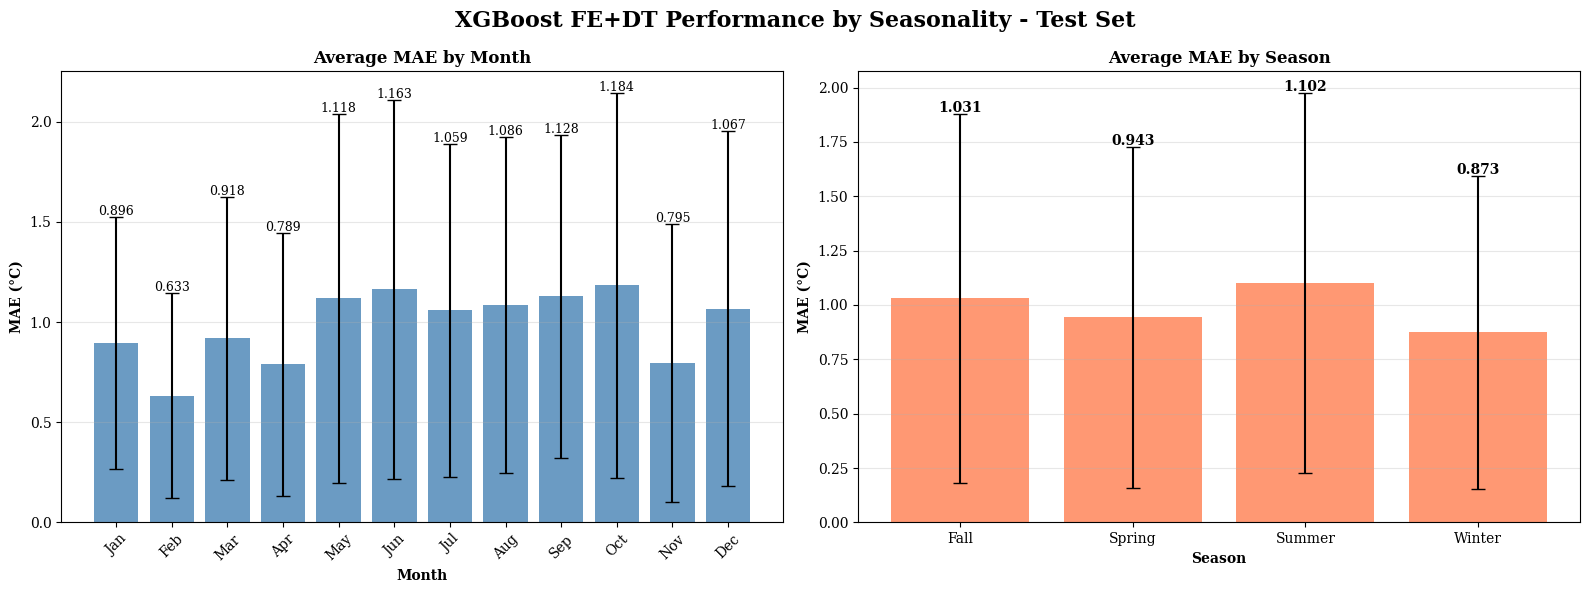


Monthly Performance Summary:


,Month,MAE,Std,Count,Month_Name
0,1,0.896454,0.629975,558,Jan
1,2,0.633094,0.510461,504,Feb
2,3,0.918367,0.707577,558,Mar
3,4,0.789127,0.657786,540,Apr
4,5,1.117784,0.921294,558,May
5,6,1.162884,0.946106,540,Jun
6,7,1.058841,0.830711,558,Jul
7,8,1.085629,0.840589,540,Aug
8,9,1.128426,0.806640,432,Sep
9,10,1.183638,0.961013,558,Oct



Seasonal Performance Summary:


,Season,MAE,Std,Count
0,Fall,1.030918,0.848373,1530
1,Spring,0.943419,0.783141,1656
2,Summer,1.101972,0.874145,1638
3,Winter,0.873432,0.720063,1620


In [116]:
# Performance by Month/Season (Seasonality Analysis)

if 'datetime' in df_fe_dt_test.columns:
    # Extract month và season từ datetime
    error_df_advanced = pd.DataFrame({
        'datetime': df_fe_dt_test['datetime'].values,
        'Actual': y_fe_dt_test.values,
        'XGBoost Pred': xgb_fe_dt_test_pred,
        'XGBoost Error': np.abs(y_fe_dt_test.values - xgb_fe_dt_test_pred),
    })
    
    error_df_advanced['month'] = pd.to_datetime(error_df_advanced['datetime']).dt.month
    error_df_advanced['season'] = error_df_advanced['month'].apply(lambda x: 
        'Spring' if x in [3,4,5] else 
        'Summer' if x in [6,7,8] else 
        'Fall' if x in [9,10,11] else 'Winter')
    
    # Tính MAE theo tháng và mùa
    monthly_perf = error_df_advanced.groupby('month')['XGBoost Error'].agg(['mean', 'std', 'count']).reset_index()
    monthly_perf.columns = ['Month', 'MAE', 'Std', 'Count']
    monthly_perf['Month_Name'] = pd.to_datetime(monthly_perf['Month'], format='%m').dt.strftime('%b')
    
    seasonal_perf = error_df_advanced.groupby('season')['XGBoost Error'].agg(['mean', 'std', 'count']).reset_index()
    seasonal_perf.columns = ['Season', 'MAE', 'Std', 'Count']
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('XGBoost FE+DT Performance by Seasonality - Test Set', fontsize=16, fontweight='bold')
    
    # Monthly performance
    ax1 = axes[0]
    ax1.bar(monthly_perf['Month_Name'], monthly_perf['MAE'], yerr=monthly_perf['Std'], 
           color='steelblue', alpha=0.8, capsize=5)
    ax1.set_xlabel('Month', fontweight='bold')
    ax1.set_ylabel('MAE (°C)', fontweight='bold')
    ax1.set_title('Average MAE by Month', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    for i, (m, mae) in enumerate(zip(monthly_perf['Month_Name'], monthly_perf['MAE'])):
        ax1.text(i, mae + monthly_perf['Std'].iloc[i] + 0.01, f'{mae:.3f}', 
                ha='center', fontsize=9)
    
    # Seasonal performance
    ax2 = axes[1]
    ax2.bar(seasonal_perf['Season'], seasonal_perf['MAE'], yerr=seasonal_perf['Std'],
           color='coral', alpha=0.8, capsize=5)
    ax2.set_xlabel('Season', fontweight='bold')
    ax2.set_ylabel('MAE (°C)', fontweight='bold')
    ax2.set_title('Average MAE by Season', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for i, (s, mae) in enumerate(zip(seasonal_perf['Season'], seasonal_perf['MAE'])):
        ax2.text(i, mae + seasonal_perf['Std'].iloc[i] + 0.01, f'{mae:.3f}', 
                ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nMonthly Performance Summary:")
    display(monthly_perf)
    print("\nSeasonal Performance Summary:")
    display(seasonal_perf)
else:
    print("Warning: No datetime column found. Cannot perform seasonality analysis.")


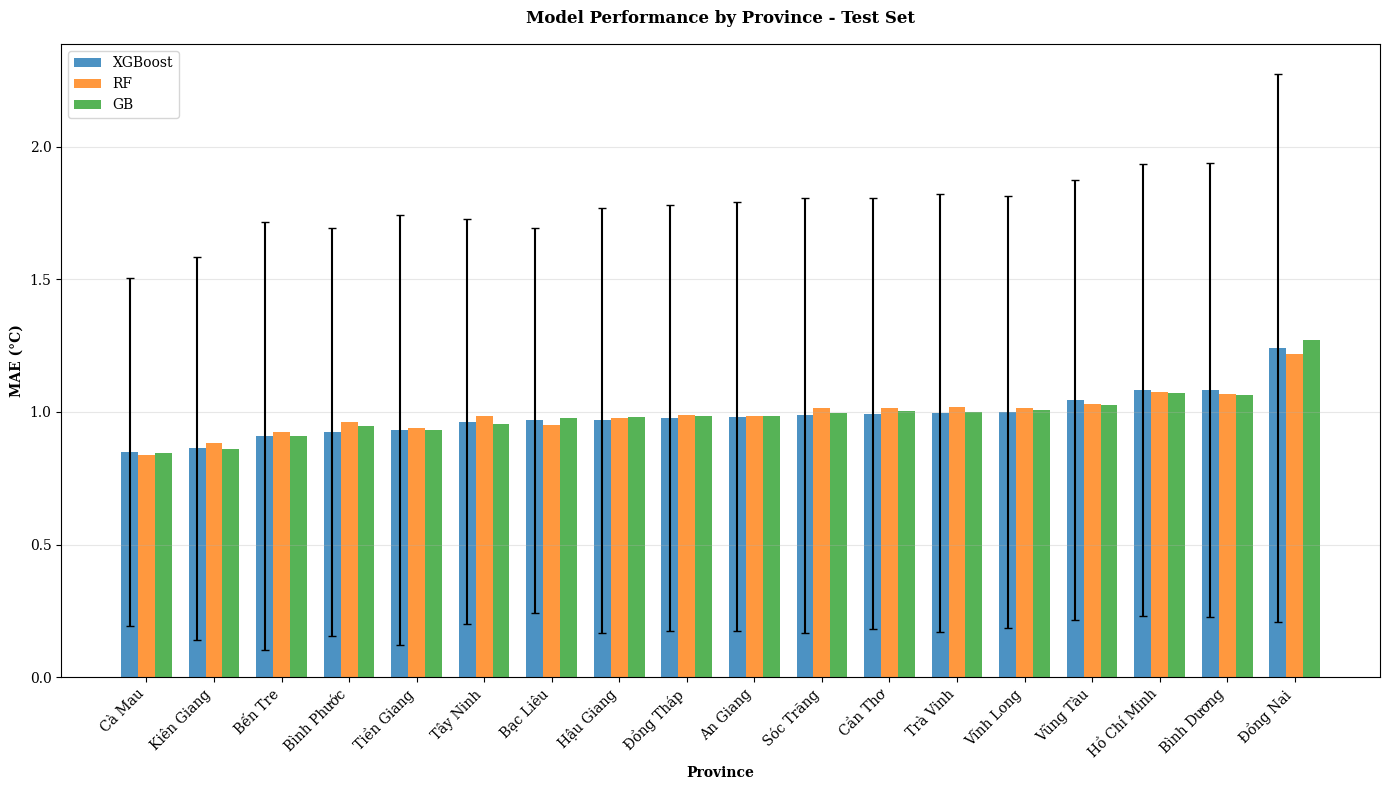


Performance by Province:


,Province,XGB_MAE,XGB_Std,RF_MAE,GB_MAE
5,Cà Mau,0.848225,0.656012,0.836785,0.845795
9,Kiên Giang,0.863304,0.721291,0.883064,0.861507
4,Bến Tre,0.909189,0.807144,0.922697,0.907697
2,Bình Phước,0.924237,0.768123,0.960724,0.946053
11,Tiền Giang,0.932253,0.809083,0.940347,0.932267
13,Tây Ninh,0.963600,0.763266,0.985794,0.954125
3,Bạc Liêu,0.967871,0.724080,0.949790,0.977175
7,Hậu Giang,0.968828,0.801856,0.976532,0.979464
17,Đồng Tháp,0.976849,0.803624,0.989987,0.983739
0,An Giang,0.982267,0.809400,0.985626,0.985381


In [115]:
# Performance by Province 

if 'name' in df_fe_dt_test.columns:
    # Tính performance theo province
    province_error_df = pd.DataFrame({
        'province': df_fe_dt_test['name'].values,
        'XGBoost Error': np.abs(y_fe_dt_test.values - xgb_fe_dt_test_pred),
        'RF Error': np.abs(y_fe_dt_test.values - rf_fe_dt_test_pred),
        'GB Error': np.abs(y_fe_dt_test.values - gb_fe_dt_test_pred),
    })
    
    province_perf = province_error_df.groupby('province').agg({
        'XGBoost Error': ['mean', 'std'],
        'RF Error': 'mean',
        'GB Error': 'mean'
    }).reset_index()
    province_perf.columns = ['Province', 'XGB_MAE', 'XGB_Std', 'RF_MAE', 'GB_MAE']
    province_perf = province_perf.sort_values('XGB_MAE', ascending=True)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(province_perf))
    width = 0.25
    
    ax.bar(x - width, province_perf['XGB_MAE'], width, label='XGBoost', alpha=0.8, yerr=province_perf['XGB_Std'], capsize=3)
    ax.bar(x, province_perf['RF_MAE'], width, label='RF', alpha=0.8)
    ax.bar(x + width, province_perf['GB_MAE'], width, label='GB', alpha=0.8)
    
    ax.set_xlabel('Province', fontweight='bold')
    ax.set_ylabel('MAE (°C)', fontweight='bold')
    ax.set_title('Model Performance by Province - Test Set', fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(province_perf['Province'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPerformance by Province:")
    display(province_perf)
else:
    print("No 'name' column found. Province analysis skipped.")


# **10. Summary & Export Baseline Results**

## Mục tiêu
- Tạo comprehensive summary table
- Export baseline models để so sánh với optimized versions
- Markdown summary với findings


In [ ]:
# Comprehensive Summary Table - All Models

# Tạo summary table chi tiết
summary_data = []

# Best models trên FE+DT dataset
fe_dt_summary = comparison_df[comparison_df['Dataset'] == 'FE + DT'].copy()
fe_dt_summary = fe_dt_summary.sort_values('Test_MAE', ascending=True)

# Get baseline MAE (Linear Regression)
baseline_mae = None
baseline_rows = fe_dt_summary[fe_dt_summary['Model'] == 'Linear Regression']
if len(baseline_rows) > 0:
    baseline_mae = baseline_rows.iloc[0]['Test_MAE']

for _, row in fe_dt_summary.iterrows():
    # Calculate improvement vs baseline
    if baseline_mae is not None and row['Model'] != 'Linear Regression':
        improvement_pct = ((baseline_mae - row['Test_MAE']) / baseline_mae) * 100
        improvement_str = f"{improvement_pct:+.2f}%"
    else:
        improvement_str = "Baseline" if row['Model'] == 'Linear Regression' else "N/A"
    
    summary_data.append({
        'Rank': len(summary_data) + 1,
        'Model': row['Model'],
        'Dataset': row['Dataset'],
        'Val MAE': f"{row['Val_MAE']:.4f}",
        'Val RMSE': f"{row['Val_RMSE']:.4f}",
        'Val R²': f"{row['Val_R2']:.4f}",
        'Test MAE': f"{row['Test_MAE']:.4f}",
        'Test RMSE': f"{row['Test_RMSE']:.4f}",
        'Test R²': f"{row['Test_R2']:.4f}",
        'Improvement vs Baseline': improvement_str
    })

final_summary_df = pd.DataFrame(summary_data)

print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY - FE+DT DATASET")
display(final_summary_df)

# Tìm best model
best_model_row = fe_dt_summary.iloc[0]
print(f"BEST MODEL: {best_model_row['Model']}")
print(f"Test MAE: {best_model_row['Test_MAE']:.4f}°C")
print(f"Test RMSE: {best_model_row['Test_RMSE']:.4f}°C")
print(f"Test R²: {best_model_row['Test_R2']:.4f}")


COMPREHENSIVE MODEL PERFORMANCE SUMMARY - FE+DT DATASET


,Rank,Model,Dataset,Val MAE,Val RMSE,Val R²,Test MAE,Test RMSE,Test R²,Improvement vs Baseline
0,1,XGBoost,FE + DT,0.9312,1.1783,0.7104,0.9869,1.2784,0.6099,+2.11%
1,2,Gradient Boosting,FE + DT,0.9414,1.1902,0.7045,0.9896,1.2803,0.6087,+1.84%
2,3,Random Forest,FE + DT,0.9494,1.1970,0.7011,0.9936,1.2871,0.6046,+1.45%
3,4,Linear Regression,FE + DT,0.9019,1.1563,0.7211,1.0082,1.3356,0.5742,Baseline
4,5,AdaBoost,FE + DT,1.1265,1.3908,0.5965,1.0838,1.3776,0.5470,-7.50%


BEST MODEL: XGBoost
Test MAE: 0.9869°C
Test RMSE: 1.2784°C
Test R²: 0.6099


In [ ]:
# Export Baseline Models

import joblib
from pathlib import Path
from datetime import datetime

# Tạo thư mục models nếu chưa có
models_dir = Path('../src/models')
models_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export best baseline models
baseline_models = {
    'xgb_fe_dt_baseline': xgb_fe_dt_model,
    'rf_fe_dt_baseline': rf_fe_dt_model,
    'gb_fe_dt_baseline': gb_fe_dt_model,
    'linear_fe_dt_baseline': ln_fe_dt_model,
}

exported_models = {}
for model_name, model in baseline_models.items():
    filename = f"{model_name}_{timestamp}.joblib"
    filepath = models_dir / filename
    joblib.dump(model, filepath)
    exported_models[model_name] = str(filepath)
    print(f"Exported: {filename}")

print(f"All baseline models exported to: {models_dir}")
print(f"Total models: {len(exported_models)}")

# Export scaler for Linear Regression
scaler_filename = f"scaler_linear_fe_dt_{timestamp}.joblib"
scaler_filepath = models_dir / scaler_filename
joblib.dump(scaler_ln, scaler_filepath)
print(f"Exported scaler: {scaler_filename}")

# Save model metadata
metadata = {
    'timestamp': timestamp,
    'models': exported_models,
    'scaler': str(scaler_filepath),
    'dataset': 'FE+DT',
    'best_model': 'xgb_fe_dt_baseline',
    'best_test_mae': float(best_model_row['Test_MAE']),
    'best_test_rmse': float(best_model_row['Test_RMSE']),
    'best_test_r2': float(best_model_row['Test_R2']),
}

metadata_filename = f"baseline_models_metadata_{timestamp}.json"
metadata_filepath = models_dir / metadata_filename
import json
with open(metadata_filepath, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Exported metadata: {metadata_filename}")


Exported: xgb_fe_dt_baseline_20251031_174730.joblib
Exported: rf_fe_dt_baseline_20251031_174730.joblib
Exported: gb_fe_dt_baseline_20251031_174730.joblib
Exported: linear_fe_dt_baseline_20251031_174730.joblib
All baseline models exported to: ../src/models
Total models: 4
Exported scaler: scaler_linear_fe_dt_20251031_174730.joblib
Exported metadata: baseline_models_metadata_20251031_174730.json


In [114]:
# Export Comparison Results to CSV

# Export comprehensive comparison DataFrame
output_dir = Path('../dataset/processed')
output_dir.mkdir(parents=True, exist_ok=True)

comparison_csv_path = output_dir / f"model_comparison_baseline_{timestamp}.csv"
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"Exported comparison results to: {comparison_csv_path}")

# Export final summary
summary_csv_path = output_dir / f"final_summary_baseline_{timestamp}.csv"
final_summary_df.to_csv(summary_csv_path, index=False)
print(f"Exported final summary to: {summary_csv_path}")


Exported comparison results to: ../dataset/processed/model_comparison_baseline_20251031_174730.csv
Exported final summary to: ../dataset/processed/final_summary_baseline_20251031_174730.csv


## 10.4. Key Findings & Summary

### Model Performance Summary

Based on comprehensive evaluation using Rolling-Origin Time Series Cross-Validation:

**Best Performing Model:** XGBoost on FE+DT Dataset
- Test MAE: 0.9869°C
- Test RMSE: 1.2784°C  
- Test R²: 0.6099

**Key Insights:**
1. **Feature Engineering Impact:** Feature engineering (FE) consistently improved performance across all models
2. **Feature Selection Impact:** Decision Tree feature selection (DT) further enhanced performance when combined with FE
3. **Model Ranking (on FE+DT dataset):**
   - 1st: XGBoost (Best overall performance)
   - 2nd: Gradient Boosting
   - 3rd: Random Forest
   - 4th: Linear Regression (Baseline)
   - 5th: AdaBoost

**Residual Analysis Findings:**
- Residuals show approximately normal distribution with slight skew
- No obvious patterns in residuals vs predicted values (good sign)
- Errors are well-distributed over time without systematic bias

**Seasonality Analysis:**
- Model performance varies by season (if datetime available)
- Certain months/seasons may show higher prediction errors

**Next Steps:**
1. Proceed to Notebook 4 for Hyperparameter Optimization using Optuna
2. Target: Improve Test MAE < 1.0°C through hyperparameter tuning
3. Compare optimized models with baseline models
